# 0. Load X and y

In [1]:
# from backend.interface.main import main

# main()


In [2]:
%load_ext autoreload
%autoreload 2
# %run data_preprocessing_Jaris.ipynb
# %run data_preprocessing_Jaris_test.ipynb
%run SignFlow.ipynb


2023-11-24 13:49:48.937695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 13:49:49.393902: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 13:49:49.473443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jarisfenner/.pyenv/versions/3.10.6/envs/SignFlow/lib/python3.10/site-packages/cv2/../../lib64:
2023-1

✅ X has been initialized with Shape (63, 10, 150, 150, 3)!
✅ y has been initialized with Shape (63, 6)!

✅ X_aug has been initialized with Shape (88, 10, 150, 150, 3)!
✅ y_aug has been initialized with Shape (88, 6)!

✅ X_val has been initialized with Shape (19, 10, 150, 150, 3)!
✅ y_cat_val has been initialized with Shape (19, 6)!


In [3]:
# X = X_aug
print(X_aug.shape)
# y = y_cat
y = y_aug
print(y.shape)


(88, 10, 150, 150, 3)
(88, 6)


# 1. Import libraries

In [4]:
import os
import json
import numpy as np
import mediapipe as mp
# from mediapipe.solutions.drawing_utils import mp_drawing
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

mp_drawing = mp.solutions.drawing_utils


# 2. Get coordinates of X

### 2.1 Define functions to get coordinates for one frame
https://developers.google.com/mediapipe/solutions/vision/hand_landmarker
https://developers.google.com/mediapipe/solutions/vision/pose_landmarker

In [5]:
mp_holistic = mp.solutions.holistic

def detect_landmarks(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=True) as holistic:
        results = holistic.process(frame_rgb)
    return results


In [6]:
# right hand
def get_coord_for_R_hand(results):
    x_coord_R_hand = []
    y_coord_R_hand = []
    z_coord_R_hand = []

    if results.right_hand_landmarks:
        #append coordinates
        for landmark in results.right_hand_landmarks.landmark:
            if landmark:
                x_coord_R_hand.append(landmark.x)
                y_coord_R_hand.append(landmark.y)
                z_coord_R_hand.append(landmark.z)
            else:
                x_coord_R_hand.append(0)
                y_coord_R_hand.append(0)
                z_coord_R_hand.append(0)
        print("✅ Right hand detected")

    else:
        for index in range(21):
            x_coord_R_hand.append(0)
            y_coord_R_hand.append(0)
            z_coord_R_hand.append(0)
        print("❌ Right hand not detected")

    return x_coord_R_hand, y_coord_R_hand, z_coord_R_hand


In [7]:
#left hand

def get_coord_for_L_hand(results):
    x_coord_L_hand = []
    y_coord_L_hand = []
    z_coord_L_hand = []

    if results.left_hand_landmarks:
        # Append coordinates
        for landmark in results.left_hand_landmarks.landmark:
            if landmark:
                x_coord_L_hand.append(landmark.x)
                y_coord_L_hand.append(landmark.y)
                z_coord_L_hand.append(landmark.z)
            else:
                x_coord_L_hand.append(0)
                y_coord_L_hand.append(0)
                z_coord_L_hand.append(0)
        print("✅ Left hand detected")
    else:
        # No left hand detected, populate with NaN values
        for index in range(21):
            x_coord_L_hand.append(0)
            y_coord_L_hand.append(0)
            z_coord_L_hand.append(0)
        print("❌ Left hand not detected")

    return x_coord_L_hand, y_coord_L_hand, z_coord_L_hand


In [8]:
# pose
def get_coord_for_pose(results):
    x_coord_pose = []
    y_coord_pose = []
    z_coord_pose = []

    if results.pose_landmarks:
        # loop over all landmarks for each hand
        for landmark in results.pose_landmarks.landmark:
            if landmark:
                x_coord_pose.append(landmark.x)
                y_coord_pose.append(landmark.y)
                z_coord_pose.append(landmark.z)
                # print(f"Landmark X: {landmark.x}, Y: {landmark.y}, Z: {landmark.z}")
            else:
                x_coord_pose.append(0)
                y_coord_pose.append(0)
                z_coord_pose.append(0)
        print("✅ Pose detected")

    else:
        x_coord_pose = [0] * 33
        y_coord_pose = [0] * 33
        z_coord_pose = [0] * 33
        print("❌ Pose not detected")

    x_coord_pose = x_coord_pose[11:25]
    y_coord_pose = y_coord_pose[11:25]
    z_coord_pose = z_coord_pose[11:25]

    return x_coord_pose, y_coord_pose, z_coord_pose


In [9]:
#daw the annoted image

def draw_(results, frame):
    annotated_image = frame.copy()

    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.right_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS)
        print("✅ Right hand annotated")
    else:
        print("❌ Right hand not annotated")

    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.left_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS)
        print("✅ Left hand annotated")
    else:
        print("❌ Left hand not annotated")


    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.pose_landmarks,
            connections=mp_holistic.POSE_CONNECTIONS)
        print("✅ Pose annotated")
    else:
        print("❌ Pose not annotated")

    return annotated_image


In [10]:
# get a series of 168 coordinates for one frame
def coordinates_per_frame(results):
    x_coord_R_hand, y_coord_R_hand, z_coord_R_hand = get_coord_for_R_hand(results)
    x_coord_L_hand, y_coord_L_hand, z_coord_L_hand = get_coord_for_L_hand(results)
    x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)

    X_frame = x_coord_R_hand + y_coord_R_hand + z_coord_R_hand + \
          x_coord_L_hand + y_coord_L_hand + z_coord_L_hand + \
          x_coord_pose + y_coord_pose + z_coord_pose
    return X_frame


### 2.2 Try on one frame

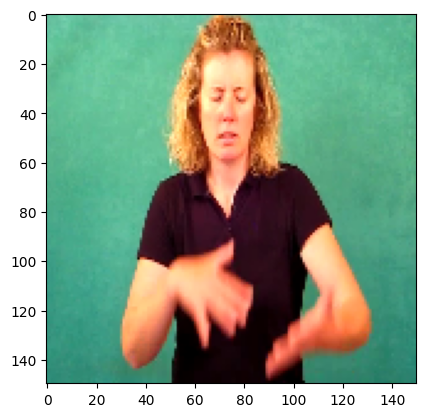

In [11]:
frame = X_aug[1][3]
# frame = X_aug[4][8]
# frame = X[15][4]
plt.imshow(frame)


In [12]:
results = detect_landmarks(frame)
x_coord_R_hand, y_coord_R_hand, z_coord_R_hand = get_coord_for_R_hand(results)
x_coord_L_hand, y_coord_L_hand, z_coord_L_hand = get_coord_for_L_hand(results)
x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)


E0000 00:00:1700801404.657522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801404.657739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801404.657750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801404.657759  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801404.657767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801404.65

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated


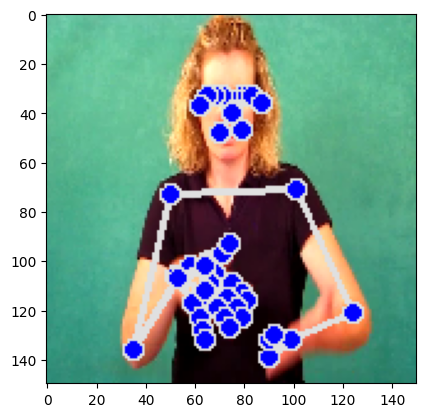

In [13]:
annotated_image = draw_(results, frame)
plt.imshow(annotated_image)


In [14]:
print(len(x_coord_R_hand))
print(len(y_coord_R_hand))
print(len(z_coord_R_hand))
print(len(x_coord_L_hand))
print(len(y_coord_L_hand))
print(len(z_coord_L_hand))
print(len(x_coord_pose))
print(len(y_coord_pose))
print(len(z_coord_pose))


21
21
21
21
21
21
14
14
14


In [15]:
X_frame = coordinates_per_frame(results)
len(X_frame)


✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


168

### 2.3 Get coordinates for all frames

In [16]:
X_aug.shape


(88, 10, 150, 150, 3)

In [17]:
def mediapipe_video_to_coord(X):
    X_coord = []

    for video_count in range(len(X)):
        video = X[video_count]
        video_frames = []

        for frame_count in range(10):
            frame = video[frame_count]
            results = detect_landmarks(frame)
            X_frame = coordinates_per_frame(results)
            video_frames.append(X_frame)

        X_coord.append(video_frames)

    X_coord = tf.convert_to_tensor(X_coord)
    return X_coord


In [18]:
X_aug_coord = mediapipe_video_to_coord(X_aug)
X_aug_coord.shape


E0000 00:00:1700801405.836886  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801405.837066  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801405.837087  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801405.837097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801405.837104  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801405.83

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801406.152606  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.152767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.152779  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.152787  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.152795  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801406.442710  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.442854  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.442866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.442875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.442882  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.44

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801406.736546  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.736700  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.736720  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.736750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.736768  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801406.73

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801407.022758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.022894  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.022904  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.022913  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.022920  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.02

✅ Right hand detected
✅ Left hand detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801407.301971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.302135  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.302147  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.302155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.302162  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.30

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801407.785191  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.785621  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.785653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.785688  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.785707  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801407.78

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801408.037795  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.037917  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.037927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.037935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.037943  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.03

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801408.316194  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.316371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.316391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.316406  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.316420  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801408.567946  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.568073  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.568083  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.568092  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.568100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801408.852027  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.852154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.852164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.852172  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.852179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801408.85

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801409.161182  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.161298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.161308  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.161315  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.161323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.16

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801409.457543  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.457713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.457724  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.457733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.457740  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.45

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801409.730468  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.730597  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.730607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.730616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.730623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801409.73

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801410.020821  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.020974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.020984  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.020993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.021000  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.02

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801410.302033  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.302149  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.302159  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.302167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.302174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.30

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801410.645384  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.645511  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.645520  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.645529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.645537  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.64

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801410.922044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.922170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.922180  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.922188  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.922196  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801410.92

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801411.220954  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.221399  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.221446  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.221481  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.221512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.22

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801411.516452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.516573  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.516583  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.516591  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.516599  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.51

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801411.791671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.791806  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.791816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.791824  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.791832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801411.79

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801412.090424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.090550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.090560  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.090569  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.090576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.09

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801412.365882  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.366006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.366016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.366024  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.366033  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801412.651349  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.651444  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.651468  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.651488  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.651501  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.65

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801412.963060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.963439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.963470  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.963493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.963513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801412.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801413.226774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.226895  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.226905  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.226912  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.226920  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.22

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801413.581951  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.582103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.582113  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.582121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.582129  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801413.925684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.925811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.925821  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.925830  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.925837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801413.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801414.269268  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.269439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.269448  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.269456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.269463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.26

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801414.592574  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.592721  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.592731  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.592739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.592746  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.59

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801414.962924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.963088  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.963097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.963106  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.963113  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801414.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801415.244860  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.245047  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.245057  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.245066  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.245074  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.24

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801415.518357  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.518478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.518487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.518495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.518503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.51

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801415.821474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.821603  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.821613  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.821621  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.821628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801415.82

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801416.103896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.104024  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.104034  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.104042  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.104050  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.10

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801416.430228  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.430381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.430392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.430400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.430408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.43

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801416.681689  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.681841  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.681851  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.681859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.681866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.68

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801416.929641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.929764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.929774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.929782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.929789  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801416.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801417.200226  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.200343  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.200353  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.200361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.200368  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.20

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801417.447303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.447428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.447438  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.447450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.447457  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.44

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801417.749312  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.749439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.749448  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.749456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.749463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.74

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801417.991123  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.991304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.991326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.991344  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.991360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801417.99

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801418.260816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.260933  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.260943  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.260951  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.260958  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.26

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801418.514115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.514233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.514243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.514250  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.514257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.51

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801418.844981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.845099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.845109  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.845117  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.845124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801418.84

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801419.106927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.107126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.107136  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.107144  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.107150  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.10

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801419.367893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.368021  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.368031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.368041  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.368048  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.36

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801419.650585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.650709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.650719  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.650729  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.650736  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.65

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801419.913883  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.914016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.914026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.914034  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.914041  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801419.91

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801420.158785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.159205  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.159238  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.159254  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.159270  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801420.402409  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.402534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.402544  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.402552  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.402559  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801420.654385  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.654503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.654513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.654521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.654529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801420.905661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.905785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.905795  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.905803  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.905811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801420.90

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801421.210527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.210755  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.210780  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.210848  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.210874  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.21

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801421.539958  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.540094  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.540104  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.540112  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.540119  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.54

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801421.789639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.789761  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.789770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.789779  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.789786  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801421.78

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801422.263147  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.263273  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.263283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.263292  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.263299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.26

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801422.509561  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.509684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.509694  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.509702  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.509709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.50

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801422.789626  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.789885  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.789902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.789911  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.789918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801422.78

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801423.067543  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.067673  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.067683  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.067691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.067698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.06

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801423.317404  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.317570  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.317580  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.317588  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.317595  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801423.567432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.567556  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.567567  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.567576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.567583  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801423.874635  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.874749  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.874758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.874767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.874774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801423.87

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801424.198395  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.198546  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.198556  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.198565  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.198572  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.19

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801424.490850  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.490967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.490977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.490986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.490993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.49

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801424.723736  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.723852  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.723862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.723870  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.723877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.72

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801424.973381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.973514  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.973524  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.973532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.973539  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801424.97

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801425.238108  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.238228  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.238239  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.238246  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.238253  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.23

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801425.525137  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.525281  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.525291  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.525300  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.525307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.52

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801425.899656  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.899797  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.899807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.899816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.899823  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801425.89

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801426.169973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.170097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.170109  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.170117  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.170124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.17

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801426.414751  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.415093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.415108  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.415117  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.415124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.41

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801426.691147  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.691442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.691479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.691508  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.691532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.69

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801426.949749  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.949872  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.949974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.949983  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.949990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801426.94

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801427.200543  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.200673  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.200683  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.200691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.200698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.20

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801427.480596  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.480718  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.480727  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.480735  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.480742  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.48

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801427.852197  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.852362  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.852373  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.852381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.852388  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801427.85

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801428.121315  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.121439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.121448  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.121456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.121463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801428.409262  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.409392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.409401  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.409410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.409417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801428.667538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.667711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.667721  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.667729  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.667736  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.66

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801428.974966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.975134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.975146  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.975154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.975164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801428.97

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801429.343505  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.343671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.343691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.343711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.343728  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.34

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801429.605679  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.605815  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.605825  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.605832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.605840  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.60

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801429.852711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.852848  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.852858  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.852867  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.852874  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801429.85

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801430.103196  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.103323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.103332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.103341  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.103348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.10

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801430.364282  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.364435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.364446  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.364454  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.364461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801430.626208  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.626330  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.626340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.626348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.626357  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.62

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801430.882406  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.882542  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.882552  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.882561  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.882568  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801430.88

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801431.206545  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.206681  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.206690  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.206699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.206706  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.20

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801431.565498  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.565618  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.565628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.565636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.565643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.56

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801431.809959  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.810092  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.810103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.810112  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.810119  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801431.81

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801432.057391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.057521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.057531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.057540  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.057547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.05

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801432.305015  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.305160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.305170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.305178  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.305185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.30

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801432.567538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.567677  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.567687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.567695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.567702  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801432.820258  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.820525  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.820537  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.820545  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.820552  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801432.82

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801433.058333  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.058462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.058472  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.058480  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.058487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.05

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801433.321646  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.321910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.321941  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.321965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.321985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.32

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801433.659230  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.659358  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.659368  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.659376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.659383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.65

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801433.952919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.953060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.953070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.953078  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.953086  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801433.95

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801434.207215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.207334  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.207342  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.207348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.207353  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.20

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801434.598495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.598620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.598630  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.598638  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.598645  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.59

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801434.862071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.862191  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.862200  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.862208  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.862215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801434.86

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801435.106206  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.106338  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.106348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.106356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.106363  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.10

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801435.404481  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.404677  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.404687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.404759  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.404795  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801435.710672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.710791  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.710801  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.710809  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.710816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.71

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801435.986451  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.986758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.986785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.986802  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.986817  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801435.98

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801436.250717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.250846  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.250856  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.250864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.250871  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.25

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801436.548873  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.549122  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.549133  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.549142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.549149  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.54

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801436.796845  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.796983  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.796992  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.797000  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.797010  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801436.79

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801437.049918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.050046  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.050056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.050064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.050072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.05

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801437.320165  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.320289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.320298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.320307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.320314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.32

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801437.567462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.567703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.567730  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.567750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.567766  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801437.845803  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.845933  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.845943  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.845951  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.845959  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801437.84

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801438.093499  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.093641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.093652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.093661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.093668  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.09

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801438.359851  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.359978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.359988  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.359996  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.360003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801438.618347  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.618477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.618487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.618496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.618503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.61

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801438.840134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.840218  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.840224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.840229  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.840234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801438.84

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801439.120940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.121013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.121019  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.121024  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.121028  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801439.395420  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.395506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.395512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.395516  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.395521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.39

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801439.684156  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.684233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.684239  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.684243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.684248  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.68

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801439.906077  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.906156  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.906162  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.906167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.906171  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801439.90

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801440.183196  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.183269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.183275  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.183280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.183285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.18

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801440.470160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.470237  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.470243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.470247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.470252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.47

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801440.805909  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.806044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.806054  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.806063  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.806070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801440.80

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801441.045557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.045691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.045701  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.045709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.045717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.04

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801441.306076  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.306361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.306371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.306380  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.306387  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.30

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801441.593261  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.593386  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.593396  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.593405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.593412  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.59

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801441.844377  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.844509  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.844521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.844532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.844540  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801441.84

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801442.123584  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.123756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.123768  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.123777  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.123785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801442.355220  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.355342  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.355352  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.355360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.355368  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.35

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801442.597766  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.598157  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.598195  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.598209  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.598221  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.59

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801442.879579  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.879695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.879705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.879713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.879721  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801442.87

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801443.108632  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.108750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.108760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.108768  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.108775  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.10

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801443.394245  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.394371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.394381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.394390  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.394397  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.39

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801443.732529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.732660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.732670  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.732678  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.732685  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.73

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801443.976884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.977010  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.977020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.977028  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.977035  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801443.97

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801444.226772  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.226900  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.226909  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.226918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.226925  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.22

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801444.466746  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.466968  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.466986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.466995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.467003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.46

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801444.777184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.777317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.777327  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.777336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.777346  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801444.77

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801445.021026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.021148  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.021158  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.021166  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.021173  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.02

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801445.272893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.273014  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.273023  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.273032  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.273039  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.27

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801445.532789  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.533060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.533078  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.533096  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.533109  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.53

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801445.855849  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.855967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.855977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.855985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.855992  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801445.85

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801446.088756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.088875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.088885  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.088893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.088900  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.08

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801446.338694  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.338826  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.338835  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.338844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.338851  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.33

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801446.580861  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.581158  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.581168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.581176  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.581184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801446.888668  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.888800  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.888810  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.888819  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.888827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801446.88

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801447.119883  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.120176  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.120187  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.120195  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.120203  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801447.393081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.393214  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.393224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.393233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.393240  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.39

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801447.651820  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.651940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.651950  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.651958  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.651965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801447.890581  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.890713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.890723  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.890731  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.890738  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801447.89

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801448.195321  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.195446  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.195456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.195464  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.195472  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.19

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801448.431946  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.432270  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.432281  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.432290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.432298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.43

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801448.715379  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.716156  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.716172  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.716184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.716194  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.71

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801448.963629  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.963745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.963755  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.963764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.963771  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801448.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801449.198481  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.198603  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.198613  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.198621  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.198630  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.19

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801449.440934  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.441142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.441154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.441164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.441174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.44

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801449.766271  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.766388  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.766397  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.766407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.766414  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801449.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801450.080432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.080511  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.080517  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.080522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.080526  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.08

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801450.358795  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.358876  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.358882  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.358887  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.358891  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.35

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801450.635313  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.635415  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.635421  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.635427  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.635432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.63

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801450.991404  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.991522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.991532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.991540  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.991547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801450.99

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801451.269151  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.269276  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.269286  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.269294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.269301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.26

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801451.509180  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.509322  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.509332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.509340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.509348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.50

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801451.769737  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.769880  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.769890  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.769898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.769909  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801451.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801452.033451  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.033655  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.033665  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.033675  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.033683  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.03

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801452.291114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.291235  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.291245  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.291253  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.291260  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.29

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801452.555918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.556036  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.556046  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.556054  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.556061  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.55

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801452.787408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.787541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.787550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.787559  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.787566  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801452.78

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801453.033827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.033957  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.033967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.033975  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.033982  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.03

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801453.275759  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.275898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.275908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.275916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.275924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.27

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801453.545466  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.545584  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.545594  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.545602  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.545609  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.54

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801453.785741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.785862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.785872  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.785880  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.785888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801453.78

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801454.057538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.057670  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.057679  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.057688  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.057695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.05

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801454.299729  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.299849  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.299859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.299868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.299876  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.29

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801454.549644  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.549764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.549774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.549782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.549791  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.54

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801454.825232  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.825356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.825366  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.825374  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.825381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801454.82

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801455.059995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.060116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.060126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.060134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.060141  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.06

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801455.304840  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.304968  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.304978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.304986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.304993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.30

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801455.585682  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.585816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.585825  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.585834  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.585841  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801455.811578  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.811720  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.811730  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.811739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.811746  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801455.81

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801456.080477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.080599  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.080609  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.080617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.080624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.08

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801456.326157  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.326284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.326293  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.326304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.326311  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.32

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801456.535500  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.535510  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.535518  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.535527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.535535  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.53

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801456.810009  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.810478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.810527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.810557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.810584  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801456.81

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801457.075943  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.076104  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.076114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.076122  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.076130  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.07

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801457.316989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.317119  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.317128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.317136  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.317143  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801457.563117  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.563242  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.563252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.563260  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.563267  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801457.792701  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.792903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.792921  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.792929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.792937  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801457.79

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801458.091179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.091405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.091462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.091488  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.091509  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.09

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801458.368191  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.368316  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.368326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.368335  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.368341  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801458.627326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.627474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.627484  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.627493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.627500  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.62

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801458.922947  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.923117  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.923127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.923135  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.923142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801458.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801459.232252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.232436  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.232451  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.232465  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.232477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.23

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801459.521169  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.521340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.521351  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.521360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.521367  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.52

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801459.766575  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.766699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.766708  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.766717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.766724  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801459.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801460.036328  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.036463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.036474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.036483  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.036490  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.03

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801460.320390  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.320545  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.320555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.320563  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.320574  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.32

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801460.611155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.611346  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.611360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.611373  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.611384  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.61

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801460.865253  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.865381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.865392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.865399  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.865408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801460.86

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801461.131837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.132022  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.132035  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.132048  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.132058  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.13

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801461.483423  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.483607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.483622  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.483635  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.483647  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.48

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801461.762016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.762157  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.762167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.762177  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.762185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801461.76

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801462.018683  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.018853  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.018866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.018878  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.018887  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.01

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801462.320609  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.320828  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.320846  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.320862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.320876  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.32

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801462.633132  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.633374  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.633440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.633463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.633482  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.63

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801462.898843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.899201  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.899229  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.899244  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.899256  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801462.89

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801463.180778  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.181253  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.181282  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.181297  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.181307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.18

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801463.441229  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.441376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.441386  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.441395  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.441404  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.44

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801463.778724  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.778851  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.778860  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.778869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.778877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801463.77

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801464.036220  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.036376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.036386  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.036426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.036462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.03

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801464.368691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.368827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.368837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.368846  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.368853  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801464.632737  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.632867  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.632876  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.632884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.632892  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.63

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801464.965106  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.965236  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.965246  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.965254  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.965262  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801464.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801465.300200  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.300412  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.300430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.300443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.300453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.30

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801465.582107  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.582257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.582266  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.582275  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.582282  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801465.861444  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.861566  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.861576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.861584  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.861591  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801465.86

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801466.140130  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.140277  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.140287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.140296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.140304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.14

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801466.405067  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.405205  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.405214  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.405223  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.405230  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801466.701441  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.701576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.701585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.701593  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.701601  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.70

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801466.957250  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.957464  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.957474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.957482  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.957493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801466.95

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801467.200605  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.201031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.201053  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.201064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.201071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.20

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801467.498493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.498701  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.498721  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.498739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.498757  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.49

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801467.778602  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.778751  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.778761  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.778769  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.778779  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801467.77

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801468.123319  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.123556  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.123573  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.123588  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.123601  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801468.394783  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.394910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.394920  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.394928  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.394939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.39

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801468.675645  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.675820  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.675829  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.675838  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.675846  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.67

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801468.981701  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.981851  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.981861  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.981870  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.981877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801468.98

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801469.232831  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.232989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.233001  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.233011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.233021  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.23

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801469.564082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.564257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.564271  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.564284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.564295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.56

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801469.882345  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.882596  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.882616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.882635  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.882650  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801469.88

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801470.156403  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.156530  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.156539  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.156548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.156555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.15

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801470.408129  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.408262  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.408271  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.408280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.408287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.40

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801470.688670  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.688919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.688934  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.688947  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.688958  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.68

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801470.981116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.981304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.981324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.981347  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.981365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801470.98

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801471.263467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.263638  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.263651  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.263662  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.263672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.26

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801471.574817  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.574940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.574950  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.574959  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.574966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.57

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801471.807459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.807585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.807595  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.807604  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.807611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801471.80

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801472.096459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.096586  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.096595  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.096603  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.096610  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.09

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801472.332378  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.332509  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.332519  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.332527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.332534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.33

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801472.616355  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.616505  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.616515  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.616523  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.616530  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.61

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801472.862052  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.862184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.862194  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.862203  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.862210  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801472.86

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801473.150286  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.150420  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.150430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.150438  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.150446  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801473.390864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.390993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.391003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.391011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.391018  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.39

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801473.641623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.642203  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.642217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.642227  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.642235  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.64

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801473.883399  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.883525  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.883535  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.883544  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.883551  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801473.88

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801474.124501  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.124631  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.124641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.124649  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.124656  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801474.372837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.372963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.372973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.372981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.372988  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.37

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801474.615590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.615760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.615770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.615778  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.615785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.61

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801474.928514  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.928633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.928643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.928651  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.928660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801474.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801475.162767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.162898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.162908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.162916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.162924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.16

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801475.418670  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.418807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.418817  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.418825  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.418833  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.41

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801475.653303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.653613  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.653623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.653631  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.653638  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801475.956417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.956538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.956547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.956555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.956562  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801475.95

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801476.183807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.184144  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.184155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.184164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.184171  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.18

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801476.473445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.473587  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.473598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.473607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.473614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.47

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801476.761869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.761995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.762005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.762013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.762020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801476.994575  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.994709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.994723  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.994732  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.994739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801476.99

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801477.228737  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.228868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.228878  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.228886  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.228893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.22

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801477.502305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.502434  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.502444  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.502452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.502459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.50

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801477.786854  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.786979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.786989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.786998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.787005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801477.78

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801478.021856  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.021998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.022008  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.022019  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.022027  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.02

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801478.294917  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.295055  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.295066  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.295073  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.295081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.29

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801478.579868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.579988  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.579997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.580005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.580015  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801478.818338  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.818634  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.818643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.818652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.818659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801478.81

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801479.087616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.087862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.087881  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.087899  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.087912  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.08

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801479.395548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.395676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.395686  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.395694  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.395701  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.39

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801479.637850  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.637997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.638006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.638016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.638023  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.63

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801479.932936  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.933094  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.933105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.933117  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.933126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801479.93

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801480.171405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.171533  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.171542  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.171550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.171558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.17

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801480.404810  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.404949  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.404961  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.404969  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.404976  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801480.692906  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.693034  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.693044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.693053  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.693060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.69

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801480.936242  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.936392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.936402  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.936411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.936418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801480.93

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801481.225533  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.225653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.225663  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.225671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.225678  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.22

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801481.488497  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.488625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.488634  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.488642  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.488649  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.48

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801481.728280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.728417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.728427  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.728435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.728443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.72

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801481.967749  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.967898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.967908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.967916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.967923  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801481.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801482.240319  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.240433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.240443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.240451  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.240458  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.24

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801482.634962  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.635088  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.635098  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.635107  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.635115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.63

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801482.852620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.852815  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.852830  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.852844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.852856  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801482.85

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801483.174581  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.174991  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.175038  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.175073  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.175103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.17

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801483.422570  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.422749  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.422762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.422774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.422783  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.42

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801483.662230  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.662379  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.662389  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.662397  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.662405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801483.66

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801484.065690  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.065825  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.065835  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.065843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.065850  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.06

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801484.300512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.300640  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.300650  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.300659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.300666  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.30

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801484.781289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.781413  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.781424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.781432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.781439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801484.78

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801485.011010  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.011145  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.011154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.011162  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.011169  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.01

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801485.254932  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.255099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.255111  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.255121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.255129  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.25

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801485.504165  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.504300  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.504310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.504317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.504326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.50

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801485.746743  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.746998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.747056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.747068  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.747076  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801485.74

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801486.169871  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.170001  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.170011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.170019  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.170026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.17

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801486.433342  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.433500  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.433511  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.433519  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.433527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.43

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801486.886321  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.886467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.886477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.886486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.886493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801486.88

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801487.194445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.194857  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.194902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.194937  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.194966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.19

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801487.444796  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.444937  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.444947  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.444955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.444962  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.44

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801487.680438  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.680572  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.680582  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.680590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.680598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.68

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801487.920450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.920571  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.920580  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.920590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.920597  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801487.92

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801488.180916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.181042  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.181051  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.181060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.181067  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.18

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801488.421803  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.421945  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.421955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.421964  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.421972  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.42

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801488.695305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.695430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.695439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.695448  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.695455  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.69

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801488.968877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.969160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.969176  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.969185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.969192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801488.96

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801489.195604  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.195733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.195742  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.195750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.195757  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.19

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801489.451604  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.451764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.451774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.451782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.451789  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.45

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801489.713557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.713682  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.713693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.713702  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.713709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.71

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801489.943728  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.943879  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.943889  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.943899  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.943906  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801489.94

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801490.208503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.208642  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.208652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.208661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.208668  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.20

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801490.465197  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.465326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.465336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.465343  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.465351  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.46

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801490.704611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.704768  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.704780  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.704788  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.704796  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.70

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801490.969982  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.970182  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.970199  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.970212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.970224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801490.97

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801491.254315  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.254450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.254460  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.254469  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.254476  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.25

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801491.514574  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.514703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.514713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.514722  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.514729  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.51

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801491.875234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.875360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.875370  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.875379  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.875388  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801491.87

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801492.110796  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.111061  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.111070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.111078  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.111084  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.11

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801492.390444  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.390571  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.390581  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.390591  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.390598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.39

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801492.633672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.633876  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.633887  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.633895  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.633903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.63

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801492.920132  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.920507  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.920640  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.920681  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.920693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801492.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801493.157319  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.157423  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.157437  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.157447  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.157456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801493.528797  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.528922  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.528932  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.528940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.528947  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.52

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801493.767213  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.767345  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.767355  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.767364  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.767371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801493.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801494.011961  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.012093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.012105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.012113  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.012120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.01

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801494.310236  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.310510  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.310545  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.310574  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.310598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801494.557938  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.558078  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.558090  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.558097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.558105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.55

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801494.794159  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.794307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.794316  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.794325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.794332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801494.79

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801495.035561  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.035685  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.035695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.035703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.035710  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.03

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801495.317763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.317894  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.317903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.317911  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.317919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801495.564203  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.564331  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.564340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.564348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.564356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801495.813617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.813755  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.813766  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.813774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.813782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801495.81

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801496.128242  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.128389  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.128399  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.128408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.128415  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801496.367356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.367584  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.367598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.367607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.367614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801496.608724  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.608875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.608888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.608897  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.608904  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.60

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801496.894607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.894745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.894757  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.894765  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.894772  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801496.89

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801497.128335  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.128720  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.128730  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.128738  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.128745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801497.388291  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.388454  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.388467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.388477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.388490  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.38

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801497.686025  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.686158  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.686167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.686176  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.686183  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.68

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801497.918672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.918812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.918823  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.918831  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.918839  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801497.91

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801498.234372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.234649  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.234669  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.234687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.234702  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.23

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801498.516155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.516280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.516289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.516298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.516305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.51

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801498.761863  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.761993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.762003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.762011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.762018  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801498.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801499.035583  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.035743  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.035754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.035765  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.035774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.03

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801499.365500  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.365625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.365635  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.365644  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.365651  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801499.635428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.635566  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.635576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.635584  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.635592  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.63

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801499.974292  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.974594  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.974627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.974653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.974727  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801499.97

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801500.220318  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.220472  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.220486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.220496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.220506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.22

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801500.471659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.471811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.471821  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.471832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.471840  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.47

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801500.797154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.797323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.797336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.797348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.797361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801500.79

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801501.071971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.072100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.072112  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.072120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.072128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.07

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801501.301998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.302119  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.302128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.302137  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.302145  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.30

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801501.586914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.587080  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.587091  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.587100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.587107  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.58

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801501.897546  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.897674  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.897683  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.897723  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.897734  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801501.89

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801502.134238  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.134372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.134382  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.134390  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.134397  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.13

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801502.377114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.377500  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.377515  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.377527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.377538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.37

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801502.632537  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.632677  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.632687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.632695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.632702  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.63

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801502.904113  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.904257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.904268  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.904277  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.904284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801502.90

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801503.187713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.187858  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.187869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.187877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.187884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.18

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801503.427121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.427247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.427257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.427265  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.427273  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.42

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801503.725443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.725638  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.725655  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.725669  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.725680  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801503.72

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801504.151025  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.151170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.151181  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.151190  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.151199  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.15

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801504.397762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.397892  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.397902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.397911  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.397918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.39

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801504.660125  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.660342  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.660360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.660376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.660389  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.66

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801504.941149  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.941284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.941294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.941303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.941310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801504.94

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801505.183733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.183884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.183894  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.183903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.183910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.18

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801505.424409  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.424535  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.424545  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.424553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.424560  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.42

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801505.706794  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.706939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.706954  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.706966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.706976  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.70

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801505.968489  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.968680  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.968693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.968705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.968715  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801505.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801506.215262  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.215391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.215402  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.215410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.215417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.21

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801506.519285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.519535  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.519552  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.519568  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.519581  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.51

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801506.836844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.836977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.836986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.836995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.837002  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801506.83

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801507.070179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.070328  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.070337  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.070346  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.070353  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.07

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801507.307631  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.307772  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.307782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.307790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.307798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.30

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801507.591952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.592075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.592084  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.592093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.592101  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.59

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801507.883707  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.883887  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.883897  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.883906  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.883913  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801507.88

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801508.128884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.129103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.129116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.129126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.129135  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.12

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801508.415352  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.415478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.415488  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.415496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.415504  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.41

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801508.667050  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.667185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.667195  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.667204  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.667211  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.66

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801508.904355  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.904607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.904625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.904633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.904641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801508.90

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801509.172039  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.172290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.172306  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.172321  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.172333  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.17

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801509.469192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.469340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.469350  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.469358  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.469366  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.46

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801509.712821  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.712955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.712965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.712973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.712981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.71

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801509.979900  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.980043  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.980054  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.980063  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.980070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801509.98

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801510.231741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.231875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.231884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.231894  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.231902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.23

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801510.470798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.471273  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.471306  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.471315  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.471323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.47

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801510.805727  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.805864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.805874  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.805882  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.805890  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801510.80

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801511.032059  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.032373  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.032383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.032392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.032456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.03

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801511.278705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.278831  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.278840  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.278849  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.278856  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.27

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801511.536547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.536685  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.536695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.536703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.536711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.53

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801511.835400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.835533  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.835543  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.835551  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.835558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801511.83

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801512.090699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.090830  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.090840  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.090849  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.090856  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.09

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801512.380640  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.380765  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.380775  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.380783  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.380790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.38

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801512.631214  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.631440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.631457  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.631472  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.631486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.63

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801512.979542  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.979673  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.979683  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.979692  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.979699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801512.97

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801513.240326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.240458  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.240468  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.240477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.240485  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.24

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801513.483620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.483757  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.483767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.483775  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.483783  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.48

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801513.765874  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.766019  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.766031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.766039  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.766049  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801513.76

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801514.046099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.046282  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.046296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.046307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.046317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.04

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801514.311770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.311939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.311952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.311963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.311972  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.31

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801514.594942  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.595094  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.595104  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.595114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.595121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.59

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801514.918349  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.918475  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.918484  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.918497  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.918504  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801514.91

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801515.210117  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.210256  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.210266  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.210275  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.210282  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.21

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801515.476440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.476598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.476609  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.476619  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.476627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.47

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801515.742846  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.742984  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.742996  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.743004  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.743012  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.74

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801515.987007  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.987140  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.987151  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.987159  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.987167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801515.98

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801516.271083  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.271295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.271317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.271330  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.271342  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.27

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801516.544127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.544268  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.544280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.544288  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.544296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.54

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801516.826482  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.826707  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.826722  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.826734  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.826743  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801516.82

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801517.145248  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.145396  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.145408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.145417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.145424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.14

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801517.359763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.359903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.359913  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.359921  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.359929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.35

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801517.577423  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.577432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.577439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.577446  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.577453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.57

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801517.861672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.861806  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.861815  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.861823  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.861832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801517.86

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801518.088190  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.088366  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.088376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.088384  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.088393  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.08

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801518.318512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.318723  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.318737  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.318752  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.318882  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801518.585144  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.585285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.585295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.585304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.585311  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801518.863615  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.863744  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.863756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.863764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.863774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801518.86

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801519.137325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.137467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.137477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.137486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.137493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.13

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801519.381819  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.381968  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.381978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.381986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.381995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.38

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801519.642932  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.643065  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.643075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.643083  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.643091  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.64

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801519.909659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.909886  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.909901  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.909914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.909925  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801519.90

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801520.170151  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.170280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.170290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.170298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.170305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.17

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801520.411343  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.411486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.411496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.411504  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.411513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.41

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801520.729843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.730057  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.730073  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.730087  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.730099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.73

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801520.996756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.996971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.996986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.997001  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.997013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801520.99

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801521.281591  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.281720  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.281731  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.281740  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.281747  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.28

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801521.567770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.567929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.567942  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.567952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.567962  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801521.821712  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.821852  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.821862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.821871  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.821878  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801521.82

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801522.106184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.106317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.106326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.106334  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.106341  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.10

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801522.419128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.419330  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.419346  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.419358  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.419369  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.41

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801522.688734  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.688875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.688888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.688899  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.688909  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.68

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801522.988453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.988587  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.988598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.988607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.988614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801522.98

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801523.224036  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.224153  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.224162  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.224171  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.224178  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.22

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801523.532324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.532460  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.532470  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.532478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.532486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.53

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801523.777697  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.777844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.777855  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.777866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.777875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801523.77

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801524.058422  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.058645  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.058673  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.058696  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.058715  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.05

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801524.291837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.292045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.292058  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.292072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.292082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.29

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801524.576331  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.576521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.576534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.576548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.576558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.57

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801524.877530  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.877654  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.877664  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.877673  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.877681  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801524.87

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801525.122759  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.122948  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.122961  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.122971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.122981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801525.435321  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.435516  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.435530  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.435543  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.435553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.43

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801525.693276  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.693412  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.693421  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.693430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.693437  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.69

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801525.933290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.933443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.933452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.933461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.933469  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801525.93

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801526.210355  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.210477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.210487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.210495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.210502  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.21

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801526.464600  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.464784  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.464795  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.464805  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.464812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.46

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801526.738980  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.739270  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.739280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.739289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.739296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.73

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801526.972754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.973093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.973105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.973116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.973124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801526.97

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801527.250827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.250964  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.250975  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.250985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.250992  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.25

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801527.490380  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.490504  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.490514  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.490522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.490529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.49

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801527.810285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.810400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.810410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.810418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.810426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801527.81

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801528.042977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.043110  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.043120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.043128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.043138  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.04

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801528.248764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.248888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.248898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.248906  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.248914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.24

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801528.737313  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.737478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.737498  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.737515  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.737531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.73

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801528.984958  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.985101  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.985112  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.985121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.985128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801528.98

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801529.225359  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.225493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.225502  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.225510  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.225517  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.22

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801529.508141  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.508268  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.508278  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.508286  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.508293  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.50

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801529.880914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.881035  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.881044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.881053  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.881060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801529.88

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801530.189222  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.189348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.189359  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.189367  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.189374  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.18

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801530.657299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.657428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.657437  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.657445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.657455  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801530.943866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.944030  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.944041  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.944051  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.944060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801530.94

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801531.321517  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.321644  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.321653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.321662  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.321669  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.32

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801531.729852  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.729969  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.729979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.729987  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.729994  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.73

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801531.976664  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.976793  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.976802  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.976810  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.976818  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801531.97

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801532.309628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.310000  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.310017  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.310031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.310043  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801532.617154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.617385  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.617402  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.617417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.617429  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.61

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801532.967242  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.967588  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.967624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.967652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.967676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801532.96

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801533.212258  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.212430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.212441  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.212451  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.212462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.21

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801533.467116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.467253  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.467262  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.467271  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.467278  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.46

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801533.766148  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.766294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.766304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.766313  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.766320  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801533.76

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801534.016939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.017064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.017074  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.017082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.017089  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.01

✅ Right hand detected
✅ Left hand detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801534.286610  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.286746  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.286756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.286764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.286771  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.28

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801534.627630  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.627750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.627760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.627768  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.627775  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.62

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801534.949633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.949974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.949985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.949995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.950004  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801534.95

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801535.167874  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.168003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.168013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.168022  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.168029  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.16

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801535.562617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.562865  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.562885  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.562904  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.562919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801535.878166  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.878307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.878317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.878326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.878334  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801535.87

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801536.083684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.083808  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.083818  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.083826  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.083833  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.08

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801536.452800  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.453201  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.453263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.453301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.453331  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.45

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801536.769576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.769699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.769709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.769717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.769725  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801536.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801537.200882  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.201110  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.201133  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.201150  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.201164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.20

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801537.489299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.489433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.489444  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.489453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.489461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.48

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801537.766942  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.767067  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.767077  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.767085  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.767092  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801537.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801538.125505  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.125677  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.125687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.125695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.125703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801538.377322  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.377453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.377463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.377471  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.377479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.37

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801538.619985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.620109  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.620118  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.620127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.620134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.62

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801538.969052  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.969467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.969478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.969487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.969494  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801538.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801539.219114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.219281  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.219290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.219298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.219306  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.21

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801539.536768  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.536997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.537025  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.537056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.537074  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.53

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801539.799569  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.799708  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.799718  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.799726  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.799733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801539.79

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801540.121118  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.121259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.121269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.121279  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.121285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.12

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801540.402124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.402255  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.402265  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.402273  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.402283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.40

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801540.765985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.766126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.766136  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.766144  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.766151  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801540.76

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801541.022487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.022612  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.022622  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.022630  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.022637  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.02

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801541.358248  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.358367  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.358376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.358385  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.358391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.35

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801541.608296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.608426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.608438  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.608446  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.608453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.60

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801541.915412  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.915560  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.915570  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.915578  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.915585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801541.91

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801542.248819  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.248991  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.249029  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.249040  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.249048  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.24

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801542.572724  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.572933  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.572973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.572987  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.572994  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.57

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801542.920385  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.920571  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.920586  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.920599  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.920611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801542.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801543.303016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.303160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.303170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.303179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.303186  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.30

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801543.579862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.580138  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.580167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.580191  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.580212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801543.819042  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.819194  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.819204  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.819212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.819219  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801543.81

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801544.065060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.065194  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.065204  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.065212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.065219  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.06

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801544.394379  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.394518  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.394528  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.394537  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.394544  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.39

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801544.672958  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.673114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.673127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.673137  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.673146  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.67

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801544.954400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.954534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.954545  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.954553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.954561  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801544.95

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801545.217780  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.217910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.217923  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.217931  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.217938  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.21

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801545.581313  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.581452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.581461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.581470  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.581478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801545.834286  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.834452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.834462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.834471  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.834478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801545.83

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801546.121858  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.122021  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.122031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.122040  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.122047  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801546.436062  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.436199  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.436209  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.436217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.436224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.43

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801546.725180  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.725328  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.725338  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.725347  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.725354  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.72

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801546.998406  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.998624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.998635  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.998643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.998651  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801546.99

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801547.328706  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.328851  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.328861  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.328870  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.328877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.32

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801547.607194  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.607335  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.607345  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.607353  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.607361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.60

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801547.930250  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.930384  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.930394  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.930403  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.930412  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801547.93

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801548.176611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.176747  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.176757  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.176765  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.176772  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.17

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801548.470676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.470818  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.470828  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.470837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.470844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.47

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801548.736160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.736315  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.736325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.736334  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.736341  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801548.73

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801549.033604  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.033754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.033765  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.033774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.033782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.03

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801549.311115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.311237  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.311247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.311255  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.311263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.31

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801549.604610  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.604739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.604750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.604759  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.604767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.60

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801549.865395  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.865522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.865533  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.865541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.865548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801549.86

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801550.152893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.153030  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.153040  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.153049  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.153056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801550.453985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.454121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.454131  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.454138  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.454146  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.45

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801550.730498  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.730622  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.730632  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.730640  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.730647  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.73

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801550.999633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.999759  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.999769  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.999777  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.999787  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801550.99

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801551.281141  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.281284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.281294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.281303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.281310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.28

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801551.575283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.575801  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.575855  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.575872  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.575884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.57

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801551.877403  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.877531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.877541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.877549  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.877556  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801551.87

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801552.137006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.137142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.137152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.137160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.137167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.13

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801552.401484  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.401789  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.401822  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.401843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.401861  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801552.778533  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.778670  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.778681  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.778689  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.778698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801552.77

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801553.066352  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.066474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.066486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.066494  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.066501  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.06

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801553.330791  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.330921  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.330931  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.330939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.330948  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.33

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801553.683182  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.683350  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.683360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.683369  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.683376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801553.68

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801554.287151  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.287727  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.287815  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.287880  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.288031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.28

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801554.520680  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.520894  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.520907  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.520920  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.520929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.52

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801554.758458  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.758649  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.758659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.758667  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.758675  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801554.75

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801555.112487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.112620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.112630  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.112639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.112646  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.11

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801555.553378  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.553521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.553532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.553541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.553548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.55

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801555.819962  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.820115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.820127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.820139  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.820148  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801555.82

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801556.121943  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.122100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.122110  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.122117  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.122125  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.12

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801556.417360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.417523  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.417536  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.417549  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.417559  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.41

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801556.744188  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.744313  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.744324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.744332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.744340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801556.74

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801557.006471  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.006662  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.006676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.006689  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.006699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.00

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801557.301023  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.301158  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.301170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.301179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.301187  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.30

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801557.616248  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.616393  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.616403  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.616411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.616419  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.61

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801557.863692  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.863814  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.863824  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.863832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.863839  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801557.86

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801558.145680  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.145808  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.145818  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.145827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.145834  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.14

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801558.435909  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.436045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.436055  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.436064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.436071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.43

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801558.725955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.726143  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.726155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.726355  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.726388  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801558.72

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801559.002908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.003026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.003036  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.003045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.003052  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.00

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801559.256783  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.256933  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.256942  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.256951  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.256957  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.25

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801559.521038  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.521165  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.521174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.521182  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.521189  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.52

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801559.827997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.828442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.828475  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.828553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.828590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801559.82

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801560.085759  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.085893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.085902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.085911  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.085918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.08

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801560.398514  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.398745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.398776  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.398797  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.398817  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.39

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801560.702664  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.702788  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.702798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.702807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.702814  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.70

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801560.986528  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.986656  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.986666  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.986675  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.986682  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801560.98

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801561.286102  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.286351  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.286363  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.286372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.286380  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.28

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801561.552678  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.552815  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.552825  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.552833  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.552840  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.55

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801561.791108  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.791259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.791269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.791277  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.791284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801561.79

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801562.097278  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.097424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.097434  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.097443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.097450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.09

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801562.558189  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.558314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.558324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.558332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.558339  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.55

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801562.798884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.799207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.799233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.799242  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.799249  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801562.79

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801563.150713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.150838  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.150848  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.150856  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.150864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801563.382969  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.383110  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.383120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.383128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.383135  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.38

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801563.663990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.664383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.664423  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.664433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.664442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.66

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801563.950809  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.950941  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.950951  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.950959  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.950967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801563.95

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801564.203310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.203444  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.203454  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.203462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.203469  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.20

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801564.462653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.462890  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.462910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.462927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.462940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.46

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801564.787981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.788114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.788124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.788132  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.788139  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801564.78

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801565.033314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.033519  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.033535  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.033548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.033559  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.03

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801565.361934  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.362314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.362331  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.362346  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.362360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801565.651991  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.652184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.652198  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.652211  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.652221  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801565.958296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.958428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.958438  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.958446  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.958453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801565.95

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801566.220174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.220311  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.220321  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.220330  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.220338  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.22

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801566.466923  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.467055  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.467065  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.467073  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.467080  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.46

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801566.758481  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.758627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.758637  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.758645  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.758653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801566.75

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801567.098555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.098862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.098876  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.098884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.098891  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.09

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801567.368426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.368597  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.368607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.368624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.368636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801567.678483  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.678832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.678859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.678877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.678891  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.67

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801567.997003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.997163  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.997175  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.997183  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.997194  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801567.99

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801568.314234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.314455  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.314468  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.314481  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.314493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801568.604844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.605133  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.605152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.605170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.605186  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.60

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801568.940945  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.941087  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.941097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.941105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.941113  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801568.94

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801569.208830  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.209189  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.209210  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.209223  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.209233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.20

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801569.563643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.563781  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.563790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.563799  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.563806  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801569.840557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.840935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.840952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.840961  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.840970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801569.84

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801570.148989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.149981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.150014  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.150037  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.150058  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801570.478647  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.478774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.478783  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.478791  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.478799  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.47

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801570.735666  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.735804  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.735814  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.735823  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.735830  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801570.73

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801571.094702  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.094953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.094978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.094997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.095012  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.09

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801571.362928  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.363064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.363073  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.363081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.363088  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801571.635426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.635603  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.635613  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.635621  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.635628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.63

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801571.909504  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.909646  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.909659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.909668  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.909676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801571.90

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801572.156808  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.156935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.156945  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.156953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.156960  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801572.463252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.463398  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.463408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.463419  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.463426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.46

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801572.862324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.862454  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.862464  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.862472  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.862480  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801572.86

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801573.224487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801573.224638  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801573.224650  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801573.224661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801573.224672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801573.22

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801573.776196  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801573.776324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801573.776334  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801573.776343  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801573.776350  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801573.77

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801574.157400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.157741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.157770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.157793  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.157811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.15

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801574.627200  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.627378  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.627392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.627404  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.627415  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.62

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801574.921628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.921780  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.921792  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.921801  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.921809  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801574.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801575.200936  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.201072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.201081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.201090  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.201097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.20

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801575.547628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.547753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.547763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.547772  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.547778  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.54

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801575.863786  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.863927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.863937  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.863945  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.863953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801575.86

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801576.145143  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.145270  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.145280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.145289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.145298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.14

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801576.387278  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.387408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.387418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.387426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.387434  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.38

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801576.785864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.786149  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.786181  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.786204  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.786223  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801576.78

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801577.045687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.046004  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.046015  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.046025  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.046036  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.04

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801577.353877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.354010  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.354019  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.354027  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.354034  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.35

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801577.650026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.650314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.650339  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.650351  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.650361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801577.961547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.961679  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.961689  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.961698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.961705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801577.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801578.226546  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.226695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.226705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.226714  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.226721  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.22

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801578.562632  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.562782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.562792  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.562800  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.562807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801578.800085  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.800304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.800333  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.800345  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.800357  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801578.80

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801579.136957  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.137124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.137135  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.137143  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.137150  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.13

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801579.457404  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.457532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.457542  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.457550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.457557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.45

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801579.701726  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.701868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.701878  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.701886  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.701895  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.70

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801579.985031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.985166  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.985177  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.985185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.985192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801579.98

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801580.252186  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.252320  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.252330  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.252338  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.252346  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.25

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801580.531868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.532084  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.532103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.532118  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.532130  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.53

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801580.836168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.836299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.836309  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.836317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.836324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801580.83

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801581.136270  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.136394  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.136404  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.136412  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.136420  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.13

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801581.407875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.408095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.408112  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.408127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.408139  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801581.767133  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.767269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.767279  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.767288  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.767295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801581.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801582.027777  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.027910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.027919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.027928  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.027935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.02

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801582.314184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.314309  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.314319  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.314327  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.314334  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801582.558133  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.558277  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.558287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.558296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.558303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.55

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801582.846217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.846361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.846371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.846380  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.846387  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801582.84

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801583.133818  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.133954  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.133965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.133972  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.133979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.13

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801583.418753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.419237  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.419261  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.419280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.419295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.41

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801583.692351  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.692534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.692548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.692563  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.692573  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801583.69

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801584.046572  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.046723  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.046734  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.046743  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.046750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.04

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801584.297678  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.297826  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.297835  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.297844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.297851  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.29

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801584.603531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.603661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.603672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.603680  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.603687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.60

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801584.951691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.951848  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.951859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.951868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.951875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801584.95

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801585.192696  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.192833  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.192842  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.192851  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.192858  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.19

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801585.478789  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.478980  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.478990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.479054  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.479064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.47

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801585.756400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.756643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.756671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.756693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.756713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.75

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801585.999576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.999704  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.999713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.999721  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.999729  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801585.99

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801586.269985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.270585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.270627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.270640  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.270652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.27

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801586.592095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.592535  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.592580  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.592614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.592643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.59

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801586.849264  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.849398  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.849408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.849416  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.849424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801586.84

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801587.133936  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.134064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.134073  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.134082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.134089  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.13

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801587.376300  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.376431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.376441  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.376449  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.376456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.37

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801587.656730  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.656863  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.656875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.656883  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.656891  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801587.888309  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.888468  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.888479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.888488  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.888496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801587.88

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801588.120867  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.121020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.121030  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.121038  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.121047  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801588.380647  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.380816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.380828  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.380839  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.380849  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.38

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801588.654973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.655126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.655139  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.655149  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.655158  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801588.947268  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.947396  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.947405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.947413  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.947420  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801588.94

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801589.280816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.281012  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.281033  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.281046  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.281059  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.28

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801589.503258  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.503399  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.503409  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.503417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.503424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.50

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801589.861970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.862100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.862111  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.862119  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.862126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801589.86

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801590.163234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.163362  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.163372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.163380  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.163387  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.16

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801590.471995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.472170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.472183  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.472192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.472200  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.47

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801590.757265  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.757401  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.757411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.757420  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.757429  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801590.75

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801591.053233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.053367  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.053379  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.053388  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.053395  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.05

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801591.370006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.370130  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.370140  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.370148  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.370155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.37

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801591.606536  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.606673  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.606682  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.606691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.606698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.60

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801591.926955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.927085  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.927095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.927104  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.927111  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801591.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801592.188325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.188472  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.188481  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.188489  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.188497  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.18

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801592.448044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.448187  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.448197  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.448207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.448214  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.44

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801592.748503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.748629  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.748639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.748646  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.748654  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.74

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801592.998222  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.998367  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.998377  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.998387  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.998394  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801592.99

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801593.265627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.265844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.265865  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.265881  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.265897  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.26

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801593.522041  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.522347  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.522365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.522379  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.522392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.52

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801593.762934  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.763064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.763075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.763083  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.763091  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801593.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801594.017200  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.017340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.017350  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.017358  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.017365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.01

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801594.318946  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.319142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.319152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.319161  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.319168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801594.600078  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.600202  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.600212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.600221  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.600228  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.60

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801594.842845  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.842980  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.842989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.842998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.843005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801594.84

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801595.121373  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.121513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.121522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.121531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.121538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801595.381116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.381248  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.381258  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.381267  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.381274  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.38

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801595.629257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.629393  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.629403  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.629411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.629419  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.62

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801595.931154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.931285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.931294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.931303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.931309  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801595.93

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801596.262610  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.262734  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.262744  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.262752  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.262760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.26

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801596.547844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.547995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.548005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.548013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.548020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.54

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801596.801900  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.802100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.802113  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.802126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.802135  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801596.80

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801597.150061  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.150184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.150194  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.150201  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.150209  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801597.482143  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.482301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.482312  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.482321  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.482330  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.48

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801597.763049  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.763212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.763224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.763233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.763241  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801597.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801598.051584  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.051732  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.051745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.051756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.051765  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.05

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801598.350243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.350463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.350482  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.350498  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.350512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.35

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801598.657453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.657602  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.657613  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.657621  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.657629  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801598.937095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.937231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.937242  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.937251  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.937258  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801598.93

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801599.170272  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.170405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.170415  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.170423  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.170431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.17

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801599.589901  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.589908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.589916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.589923  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.589930  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.58

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801599.906836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.906978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.906990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.906999  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.907006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801599.90

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801600.397476  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801600.397627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801600.397636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801600.397645  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801600.397652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801600.39

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801600.748127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801600.748827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801600.748847  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801600.748866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801600.748880  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801600.74

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801601.111945  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.112479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.112633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.112668  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.112682  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.11

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801601.482832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.482961  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.482971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.482979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.482987  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.48

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801601.778872  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.779307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.779325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.779340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.779351  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801601.77

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801602.080199  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.080383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.080397  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.080409  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.080421  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.08

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801602.549372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.549537  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.549548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.549557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.549564  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.54

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801602.802942  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.803164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.803179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.803193  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.803205  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801602.80

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801603.089524  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.089853  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.089871  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.089895  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.089908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.08

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801603.353660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.353780  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.353790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.353799  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.353806  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.35

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801603.714026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.714204  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.714215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.714223  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.714231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801603.71

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801604.257494  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.257615  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.257625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.257633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.257643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.25

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801604.521195  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.521372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.521385  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.521396  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.521405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.52

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801604.846762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.846886  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.846896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.846905  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.846912  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801604.84

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801605.135594  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.135735  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.135745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.135753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.135761  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.13

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801605.378294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.378416  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.378426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.378434  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.378441  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.37

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801605.688771  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.688902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.688912  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.688920  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.688927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.68

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801605.957269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.957392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.957402  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.957411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.957418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801605.95

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801606.220902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.221035  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.221044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.221053  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.221061  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.22

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801606.525458  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.525606  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.525616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.525625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.525632  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.52

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801606.837302  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.837435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.837445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.837454  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.837461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801606.83

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801607.229852  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.230053  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.230071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.230080  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.230087  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.23

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801607.583115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.583283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.583299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.583311  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.583322  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801607.868869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.868990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.869058  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.869070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.869077  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801607.86

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801608.116087  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.116240  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.116251  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.116259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.116267  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.11

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801608.376230  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.376355  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.376366  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.376374  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.376381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.37

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801608.671170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.671298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.671308  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.671316  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.671325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.67

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801608.934964  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.935131  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.935141  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.935150  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.935157  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801608.93

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801609.218466  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.218626  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.218637  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.218647  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.218655  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.21

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801609.547516  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.547673  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.547685  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.547695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.547704  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.54

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801609.847112  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.847279  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.847289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.847298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.847306  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801609.84

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801610.106121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.106293  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.106302  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.106311  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.106318  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.10

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801610.449256  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.449629  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.449645  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.449659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.449671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.44

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801610.719903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.720051  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.720064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.720072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.720080  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.72

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801610.962829  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.962950  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.962960  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.962967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.962974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801610.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801611.211423  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801611.211558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801611.211568  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801611.211576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801611.211583  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801611.21

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801611.542116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801611.542246  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801611.542256  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801611.542265  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801611.542272  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801611.54

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801612.013435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.013567  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.013577  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.013585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.013592  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.01

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801612.297217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.297448  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.297458  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.297467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.297475  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.29

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801612.546529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.546653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.546663  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.546672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.546681  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.54

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801612.872843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.872971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.872981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.872989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.872996  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801612.87

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801613.121916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.122048  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.122057  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.122065  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.122073  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801613.398479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.398606  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.398616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.398624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.398632  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.39

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801613.706064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.706203  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.706212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.706222  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.706229  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801613.70

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801614.053679  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.053956  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.053969  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.053977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.053985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.05

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801614.301093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.301217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.301226  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.301234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.301243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.30

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801614.563230  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.563379  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.563391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.563400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.563407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.56

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801614.795833  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.795967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.795978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.795986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.795993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801614.79

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801615.121362  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.121555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.121567  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.121576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.121585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801615.404267  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.404623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.404661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.404689  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.404714  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801615.681330  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.681469  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.681479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.681487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.681495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.68

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801615.916217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.916369  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.916380  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.916389  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.916397  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801615.91

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801616.159786  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.159918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.159927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.159936  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.159943  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801616.405906  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.406032  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.406041  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.406050  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.406057  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801616.629452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.629585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.629598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.629607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.629615  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.62

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801616.971400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.972034  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.972058  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.972075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.972088  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801616.97

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801617.400891  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.401017  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.401027  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.401035  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.401042  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801617.640283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.640408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.640418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.640427  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.640435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.64

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801617.922495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.922806  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.922836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.922859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.922878  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801617.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801618.183037  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.183192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.183202  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.183210  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.183218  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.18

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801618.464669  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.464920  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.464939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.464954  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.464967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.46

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801618.733440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.733563  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.733572  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.733580  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.733590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.73

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801618.978815  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.978949  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.978959  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.978968  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.978975  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801618.97

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801619.421651  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801619.421794  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801619.421804  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801619.421812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801619.421820  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801619.42

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801619.748269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801619.748406  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801619.748416  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801619.748425  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801619.748432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801619.74

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801620.067492  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.067624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.067634  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.067642  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.067649  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.06

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801620.364534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.364671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.364681  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.364689  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.364696  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.36

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801620.635367  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.635553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.635568  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.635580  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.635591  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.63

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801620.900541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.900674  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.900684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.900693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.900700  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801620.90

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801621.230579  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.230829  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.230849  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.230867  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.230883  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.23

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801621.524159  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.524303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.524314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.524331  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.524341  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.52

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801621.771243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.771373  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.771382  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.771391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.771398  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801621.77

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801622.115965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.116121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.116134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.116144  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.116152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.11

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801622.451992  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.452140  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.452150  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.452159  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.452166  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.45

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801622.724553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.724671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.724681  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.724690  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.724697  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.72

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801622.979855  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.979984  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.979995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.980004  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.980011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801622.98

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801623.312738  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.312903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.312913  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.312922  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.312929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.31

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801623.611485  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.611611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.611621  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.611630  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.611636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.61

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801623.851419  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.851547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.851557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.851565  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.851572  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801623.85

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801624.116385  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.116527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.116538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.116547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.116555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.11

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801624.366356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.366506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.366516  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.366524  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.366531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.36

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801624.637868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.637997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.638006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.638015  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.638022  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.63

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801624.891020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.891142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.891152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.891160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.891167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801624.89

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801625.176128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.176263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.176274  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.176283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.176290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.17

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801625.447954  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.448164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.448178  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.448190  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.448201  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.44

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801625.770527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.770659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.770670  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.770679  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.770686  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801625.77

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801626.044923  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.045051  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.045062  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.045069  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.045079  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.04

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801626.338512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.338679  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.338689  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.338698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.338705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.33

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801626.618761  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.618919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.618929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.618938  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.618945  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.61

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801626.916456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.916597  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.916607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.916615  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.916623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801626.91

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801627.174138  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.174269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.174279  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.174287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.174294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.17

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801627.522505  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.522676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.522686  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.522695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.522704  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.52

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801627.792609  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.792756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.792766  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.792775  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.792782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801627.79

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801628.084070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.084233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.084243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.084251  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.084259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.08

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801628.354976  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.355108  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.355118  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.355126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.355135  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.35

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801628.662606  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.662732  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.662741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.662750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.662757  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801628.66

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801629.004927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.005267  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.005278  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.005287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.005294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.00

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801629.292216  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.292384  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.292393  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.292402  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.292409  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.29

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801629.604888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.606140  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.606158  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.606167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.606174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.60

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801629.877903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.878032  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.878042  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.878050  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.878057  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801629.87

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801630.151262  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.151445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.151457  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.151468  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.151477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.15

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801630.423463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.423611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.423620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.423629  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.423636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.42

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801630.722656  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.722801  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.722811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.722820  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.722827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.72

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801630.994826  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.994961  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.994973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.994982  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.994990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801630.99

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801631.245886  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.246069  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.246082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.246093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.246104  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.24

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801631.581977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.582109  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.582119  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.582127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.582135  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.58

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801631.869697  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.869890  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.869905  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.869918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.869929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801631.86

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801632.170163  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.170310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.170320  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.170329  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.170337  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.17

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801632.446079  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.446212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.446222  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.446231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.446240  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.44

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801632.719638  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.719772  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.719782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.719791  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.719798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.71

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801632.962640  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.962771  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.962781  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.962790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.962797  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801632.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801633.234490  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.234622  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.234634  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.234642  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.234650  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.23

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801633.498917  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.499414  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.499430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.499445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.499457  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.49

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801633.846500  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.846650  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.846660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.846669  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.846676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801633.84

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801634.123332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.123529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.123540  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.123549  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.123556  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.12

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801634.401365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.401487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.401497  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.401505  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.401512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801634.673054  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.673790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.673810  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.673820  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.673827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.67

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801634.925859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.925996  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.926006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.926014  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.926021  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801634.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801635.188419  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.188614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.188628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.188641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.188650  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.18

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801635.499447  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.499634  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.499645  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.499656  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.499664  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.49

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801635.761888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.762167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.762178  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.762186  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.762193  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801635.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801636.030178  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.030327  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.030340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.030351  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.030360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.03

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801636.326291  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.326431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.326441  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.326449  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.326456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.32

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801636.583867  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.584012  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.584022  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.584031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.584038  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801636.829387  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.829543  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.829553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.829562  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.829569  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801636.82

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801637.111059  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.111188  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.111198  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.111207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.111214  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.11

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801637.359549  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.359688  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.359698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.359706  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.359714  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.35

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801637.650788  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.650916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.650926  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.650935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.650942  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801637.954176  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.954305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.954314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.954323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.954330  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801637.95

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


2023-11-24 13:53:58.269111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jarisfenner/.pyenv/versions/3.10.6/envs/SignFlow/lib/python3.10/site-packages/cv2/../../lib64:
2023-11-24 13:53:58.269984: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-24 13:53:58.270071: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JarisLaptop): /proc/driver/nvidia/version does not exist
2023-11-24 13:53:58.273808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

TensorShape([88, 10, 168])

In [19]:
X_val_coord = mediapipe_video_to_coord(X_val)
X_val_coord.shape


E0000 00:00:1700801638.504613  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801638.504750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801638.504763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801638.504773  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801638.504780  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801638.50

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801638.918617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801638.918915  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801638.918935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801638.918944  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801638.918951  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801638.91

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801639.739538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801639.739661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801639.739671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801639.739680  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801639.739687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801639.73

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801640.248636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801640.248796  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801640.248807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801640.248816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801640.248823  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801640.24

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801640.693230  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801640.693521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801640.693567  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801640.693591  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801640.693612  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801640.69

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801641.178081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.178227  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.178237  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.178247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.178254  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.17

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801641.446456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.446592  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.446601  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.446610  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.446617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.44

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801641.751250  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.751374  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.751383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.751393  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.751400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801641.75

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801642.116377  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.116513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.116524  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.116532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.116540  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.11

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801642.438697  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.438903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.438918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.438932  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.438943  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.43

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801642.806231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.806359  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.806369  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.806377  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.806384  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801642.80

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801643.091847  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.091971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.091982  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.091991  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.091998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.09

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801643.403306  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.403430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.403440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.403448  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.403455  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801643.685704  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.685826  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.685836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.685845  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.685852  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801643.68

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801644.049710  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.049847  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.049856  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.049865  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.049873  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.04

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801644.490539  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.490665  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.490676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.490684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.490691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.49

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801644.756727  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.756867  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.756877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.756886  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.756893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801644.75

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801645.001900  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.002030  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.002041  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.002049  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.002056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.00

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801645.250411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.250541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.250552  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.250561  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.250568  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.25

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801645.584208  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.584368  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.584378  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.584386  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.584393  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.58

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801645.852378  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.852508  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.852519  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.852527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.852534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801645.85

❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801646.283860  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801646.283995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801646.284006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801646.284014  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801646.284022  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801646.28

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801646.740914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801646.741036  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801646.741046  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801646.741055  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801646.741062  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801646.74

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801647.002448  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.002579  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.002589  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.002598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.002605  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.00

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801647.254879  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.255031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.255041  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.255049  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.255056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.25

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801647.525755  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.525877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.525888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.525896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.525903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.52

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801647.802929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.803056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.803066  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.803075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.803082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801647.80

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801648.131871  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.132010  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.132020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.132029  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.132036  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.13

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801648.373892  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.374020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.374029  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.374037  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.374045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.37

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801648.618070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.618231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.618241  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.618249  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.618256  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.61

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801648.870090  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.870226  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.870236  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.870245  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.870252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801648.87

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801649.210368  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.210496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.210505  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.210513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.210521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.21

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801649.468769  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.468941  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.468952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.468963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.468971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.46

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801649.717357  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.718006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.718023  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.718031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.718039  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.71

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801649.984262  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.984493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.984509  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.984521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.984532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801649.98

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801650.243473  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.243608  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.243618  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.243627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.243636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.24

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801650.679969  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.680095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.680105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.680114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.680124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.68

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801650.944504  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.944626  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.944635  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.944644  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.944652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801650.94

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801651.227272  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.227391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.227400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.227408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.227415  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.22

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801651.487320  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.487452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.487462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.487471  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.487479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.48

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801651.727499  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.727617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.727627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.727635  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.727642  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.72

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801651.964284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.964405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.964415  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.964424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.964433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801651.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801652.200759  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.200953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.200963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.200972  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.200979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.20

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801652.438043  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.438174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.438185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.438193  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.438200  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.43

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801652.705973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.706100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.706109  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.706118  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.706125  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.70

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801652.968734  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.968976  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.968986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.969213  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.969241  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801652.96

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801653.214975  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.215095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.215105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.215113  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.215120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.21

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801653.557784  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.557924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.557934  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.557943  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.557950  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.55

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801653.830898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.831021  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.831031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.831040  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.831047  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801653.83

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801654.113639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.113766  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.113775  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.113785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.113792  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.11

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801654.401541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.401673  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.401684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.401692  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.401700  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.40

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801654.644306  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.644442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.644451  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.644460  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.644467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.64

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801654.856864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.856955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.856961  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.856966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.856970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801654.85

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801655.178992  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.179108  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.179114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.179120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.179124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.17

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801655.460660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.460744  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.460750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.460755  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.460760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.46

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801655.744864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.744940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.744946  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.744951  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.744955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801655.74

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801656.195338  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.195467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.195477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.195486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.195493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.19

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801656.441430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.441559  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.441569  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.441578  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.441584  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.44

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801656.684027  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.684157  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.684168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.684176  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.684184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.68

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801656.922719  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.922847  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.922858  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.922865  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.922872  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801656.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801657.155407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.155546  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.155556  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.155564  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.155571  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.15

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801657.397301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.397421  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.397431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.397439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.397447  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.39

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801657.691005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.691132  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.691142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.691151  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.691158  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.69

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801657.925054  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.925178  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.925188  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.925197  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.925204  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801657.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801658.163748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.163871  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.163881  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.163889  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.163897  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.16

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801658.404669  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.404798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.404807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.404816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.404824  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801658.674261  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.674388  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.674398  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.674407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.674414  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.67

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801658.911626  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.912005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.912044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.912054  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.912061  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801658.91

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801659.181600  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.181730  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.181740  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.181749  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.181756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.18

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801659.453509  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.453641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.453651  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.453660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.453668  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.45

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801659.723337  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.723532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.723542  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.723550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.723558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801659.72

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801660.020796  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.020918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.020928  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.020936  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.020943  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.02

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801660.267582  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.267727  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.267736  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.267745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.267753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.26

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801660.555360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.555805  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.555947  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.555965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.555973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.55

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801660.810855  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.811024  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.811034  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.811042  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.811050  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801660.81

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801661.025938  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.025944  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.025949  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.025953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.025958  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.02

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801661.315531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.315607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.315613  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.315618  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.315623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.31

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801661.611021  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.611108  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.611115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.611120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.611124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.61

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801661.957618  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.957698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.957704  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.957708  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.957713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801661.95

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801662.294899  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801662.294990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801662.294996  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801662.295001  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801662.295005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801662.29

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801662.673026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801662.673108  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801662.673114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801662.673119  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801662.673123  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801662.67

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801663.152390  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.152515  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.152524  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.152532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.152540  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.15

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801663.446703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.446838  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.446848  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.446857  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.446864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.44

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801663.692677  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.692809  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.692981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.692998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.693006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.69

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801663.979390  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.979558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.979578  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.979603  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.979620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801663.97

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801664.320805  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.320956  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.320967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.320981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.320995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.32

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801664.648800  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.648985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.649077  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.649089  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.649097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.64

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801664.907369  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.907509  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.907519  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.907528  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.907535  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801664.90

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801665.164774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.164905  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.164915  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.164924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.164932  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.16

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801665.409375  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.409507  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.409516  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.409524  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.409532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801665.680500  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.680619  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.680629  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.680637  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.680644  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.68

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801665.936797  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.936937  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.936947  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.936956  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.936963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801665.93

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801666.222291  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.222414  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.222424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.222433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.222440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.22

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801666.513276  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.513423  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.513433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.513442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.513449  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.51

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801666.770297  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.770421  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.770431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.770439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.770447  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801666.77

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801667.020703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.020827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.020837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.020845  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.020853  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.02

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801667.311583  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.311723  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.311734  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.311745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.311754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801667.558173  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.558487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.558606  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.558628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.558636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.55

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801667.815125  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.815256  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.815266  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.815275  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.815283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801667.81

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801668.068151  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.068275  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.068285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.068293  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.068303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.06

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801668.310350  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.310472  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.310482  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.310490  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.310497  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801668.629127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.629251  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.629261  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.629269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.629277  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.62

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801668.881789  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.882064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.882104  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.882128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.882149  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801668.88

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801669.124200  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.124325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.124336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.124344  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.124351  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.12

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801669.377062  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.377207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.377217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.377225  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.377233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.37

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801669.613383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.613527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.613537  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.613546  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.613553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.61

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801669.873641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.873951  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.873963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.873972  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.873979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801669.87

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801670.118371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.118511  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.118521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.118529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.118536  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.11

✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801670.379153  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.379287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.379297  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.379305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.379312  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.37

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801670.673101  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.673304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.673333  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.673348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.673358  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.67

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801670.998112  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.998276  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.998295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.998306  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.998322  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801670.99

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801671.279844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.280003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.280016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.280030  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.280042  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.28

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801671.544409  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.544532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.544542  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.544550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.544557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.54

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801671.807052  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.807192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.807202  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.807210  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.807217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801671.80

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801672.098337  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.098458  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.098468  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.098476  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.098483  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.09

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801672.338506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.338641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.338651  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.338659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.338667  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.33

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801672.600479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.600602  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.600612  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.600620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.600628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.60

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801672.847903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.848036  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.848046  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.848054  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.848061  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801672.84

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801673.162149  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.162271  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.162281  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.162289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.162298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.16

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801673.401967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.402349  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.402367  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.402376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.402384  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801673.666861  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.666982  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.666991  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.666999  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.667006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.66

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801673.912184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.912318  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.912327  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.912336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.912343  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801673.91

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801674.177908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.178042  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.178052  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.178060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.178068  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.17

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801674.459485  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.459628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.459643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.459658  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.459669  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.45

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801674.760605  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.760729  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.760739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.760748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.760755  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801674.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801675.054848  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.055055  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.055071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.055084  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.055095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.05

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801675.299192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.299340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.299350  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.299358  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.299365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.29

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801675.552746  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.552885  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.552896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.552904  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.552911  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.55

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801675.912592  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.912722  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.912732  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.912740  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.912748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801675.91

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801676.146315  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.146433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.146442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.146450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.146457  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.14

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801676.402290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.402414  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.402423  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.402432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.402439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.40

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801676.650147  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.650402  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.650412  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.650420  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.650428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.65

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801676.946152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.946232  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.946239  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.946244  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.946248  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801676.94

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801677.232243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.232321  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.232327  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.232332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.232336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.23

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801677.524980  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.525060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.525066  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.525071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.525075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.52

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801677.813984  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.814066  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.814072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.814077  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.814082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801677.81

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801678.103654  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.103753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.103760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.103765  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.103770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.10

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801678.387280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.387356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.387362  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.387367  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.387371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.38

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801678.668795  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.668876  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.668881  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.668886  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.668891  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801678.66

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801679.049523  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.049652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.049661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.049671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.049678  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.04

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801679.318677  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.322711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.322868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.322972  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.323647  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.32

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801679.616529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.616658  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.616668  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.616676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.616683  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.61

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801679.881649  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.881783  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.881795  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.881803  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.881811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801679.88

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801680.124605  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.124921  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.124931  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.124939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.124947  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.12

❌ Right hand not detected
✅ Left hand detected
✅ Pose detected


E0000 00:00:1700801680.378059  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.378289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.378309  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.378318  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.378326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.37

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801680.672526  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.672653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.672663  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.672672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.672679  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.67

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801680.921142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.921336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.921352  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.921365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.921377  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801680.92

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801681.169459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.169583  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.169593  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.169601  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.169608  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.16

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801681.425254  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.425379  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.425389  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.425398  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.425405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.42

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801681.662335  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.662496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.662506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.662515  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.662522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.66

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801681.919607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.919764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.919774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.919782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.919790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801681.91

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801682.173618  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.173742  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.173752  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.173760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.173767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.17

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801682.412927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.413111  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.413136  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.413154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.413167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.41

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801682.688837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.688970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.688981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.688990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.689038  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.68

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801682.933166  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.933561  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.933606  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.933632  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.933656  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801682.93

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801683.175057  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.175183  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.175192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.175201  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.175209  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.17

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801683.419261  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.419398  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.419409  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.419418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.419425  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.41

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801683.673927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.674070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.674082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.674091  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.674100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.67

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801683.993530  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.993651  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.993660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.993669  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.993676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801683.99

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801684.234468  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.234700  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.234778  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.234790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.234798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.23

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801684.483288  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.483443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.483453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.483461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.483468  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.48

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801684.759541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.759665  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.759675  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.759682  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.759693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.75

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801684.992008  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.992127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.992136  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.992144  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.992152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801684.99

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801685.236834  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.236955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.236964  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.236973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.236980  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.23

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801685.471378  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.471540  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.471549  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.471558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.471565  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.47

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801685.761437  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.761569  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.761580  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.761588  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.761863  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801685.76

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801686.063333  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.063459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.063469  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.063507  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.063523  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.06

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected


E0000 00:00:1700801686.316264  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.316406  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.316416  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.316424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.316431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.31

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801686.752310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.752501  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.752524  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.752612  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.752631  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.75

❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


E0000 00:00:1700801686.999842  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.999979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.999989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801686.999998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.000006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.00

TensorShape([19, 10, 168])

### 2.4 Get coordinates for videos?

In [20]:
word = "family"
video_list = list(selected_df[selected_df["word"] == word]["video_id"])
video_list


['69316',
 '20980',
 '20981',
 '20982',
 '20983',
 '20986',
 '20987',
 '65677',
 '20978',
 '20992',
 '20979']

In [21]:
def detect_landmarks_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=False) as holistic:
        results = holistic.process(frame_rgb)
    return results

for video in video_list:
    video_path = f"../data/videos/{video}.mp4"
    output_video_path = f"../data/videos_test/{video}_annotated.mp4"

    cap = cv2.VideoCapture(video_path)

    # Get video details
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(filename=output_video_path, fourcc=fourcc, fps=20, frameSize=(frame_width, frame_height))

    if not out.isOpened():
        print("Could not open output video file for writing.")

    while cap.isOpened():
        print("------")
        ret, frame = cap.read()
        if not ret:
            break

        # Process the frame for landmark detection
        results = detect_landmarks_frame(frame)

        # Draw landmarks on the frame
        annotated_image = draw_(results, frame)

        # Write the frame with annotations to the output video
        out.write(annotated_image)

        # cv2.imshow('Video', annotated_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()


Could not open output video file for writing.
------


E0000 00:00:1700801687.371770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.371851  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.371860  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.371866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.371870  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.37

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801687.817913  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.818001  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.818011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.818022  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.818027  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801687.81

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801688.702433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801688.702568  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801688.702581  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801688.702598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801688.702608  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801688.70

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801689.461486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801689.461607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801689.461617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801689.461626  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801689.461633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801689.46

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801690.307657  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801690.307784  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801690.307794  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801690.307803  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801690.307810  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801690.30

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801690.762319  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801690.762449  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801690.762464  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801690.762482  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801690.762497  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801690.76

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801691.089778  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.089957  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.089977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.089997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.090013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.09

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801691.486621  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.487022  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.487094  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.487160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.487224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.48

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801691.807124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.807253  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.807263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.807271  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.807278  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801691.80

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801692.093720  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.093837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.093847  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.093856  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.093863  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.09

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801692.524074  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.524224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.524244  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.524260  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.524269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.52

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801692.902392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.902612  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.902623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.902643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.902655  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801692.90

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801693.327204  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.327326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.327336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.327345  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.327352  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.32

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801693.598769  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.598912  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.598923  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.598932  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.598939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.59

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801693.991712  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.991960  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.991971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.991979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.991986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801693.99

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801694.491275  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801694.491539  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801694.491572  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801694.491598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801694.491619  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801694.49

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801694.745058  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801694.745187  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801694.745197  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801694.745206  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801694.745213  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801694.74

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801695.138193  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.138324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.138334  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.138342  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.138349  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.13

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801695.547419  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.547547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.547557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.547565  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.547572  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.54

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801695.801712  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.801840  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.801850  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.801858  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.801866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801695.80

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------
✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801696.067543  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.067674  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.067684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.067693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.067700  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.06

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------
✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801696.381435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.381512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.381518  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.381523  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.381527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.38

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------
✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801696.668431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.668514  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.668520  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.668525  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.668529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801696.66

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------
✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801697.042812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.042908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.042920  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.042926  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.042935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.04

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------
✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801697.392398  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.392475  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.392480  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.392485  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.392490  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.39

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------
✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801697.694848  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.694923  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.694929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.694934  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.694939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801697.69

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------
✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801698.008008  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.008089  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.008094  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.008100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.008104  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.00

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801698.462300  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.462425  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.462435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.462443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.462450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.46

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801698.738436  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.738555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.738566  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.738573  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.738580  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.73

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801698.984459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.984586  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.984596  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.984604  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.984611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801698.98

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801699.247983  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.248106  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.248116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.248123  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.248131  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.24

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801699.488387  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.488558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.488580  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.488599  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.488616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.48

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801699.744829  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.744952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.744962  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.744970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.744977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.74

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801699.991812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.991940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.991950  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.991959  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.991966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801699.99

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801700.234151  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.234276  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.234285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.234294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.234301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.23

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801700.483174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.483296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.483306  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.483314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.483321  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.48

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801700.767138  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.767271  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.767281  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.767290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.767297  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801700.76

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801701.065545  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.065665  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.065675  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.065683  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.065691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.06

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801701.305383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.305503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.305513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.305521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.305528  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.30

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801701.566628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.566747  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.566757  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.566765  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.566774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.56

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801701.814956  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.815079  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.815089  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.815097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.815105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801701.81

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801702.070289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.070418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.070428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.070436  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.070445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.07

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801702.304034  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.304158  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.304168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.304177  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.304184  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.30

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801702.540364  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.540483  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.540493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.540502  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.540510  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.54

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801702.780450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.780574  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.780584  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.780592  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.780599  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801702.78

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801703.021512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.021633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.021643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.021651  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.021658  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.02

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801703.274091  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.274213  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.274222  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.274231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.274238  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.27

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801703.538358  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.538478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.538487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.538495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.538502  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.53

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801703.865314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.865445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.865455  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.865463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.865471  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801703.86

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801704.184050  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.184182  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.184191  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.184199  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.184207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.18

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801704.546703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.546833  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.546843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.546852  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.546859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.54

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801704.862219  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.862402  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.862514  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.862556  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.862568  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801704.86

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801705.205098  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.205227  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.205238  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.205246  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.205253  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.20

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801705.596820  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.597256  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.597296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.597414  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.597477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.59

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801705.922283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.922422  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.922433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.922441  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.922449  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801705.92

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801706.230336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.230468  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.230478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.230487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.230494  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.23

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801706.527573  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.527694  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.527704  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.527713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.527721  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.52

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801706.771469  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.771595  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.771605  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.771614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.771623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801706.77

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801707.016970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.017098  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.017108  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.017116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.017124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.01

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801707.333180  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.333314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.333324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.333332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.333339  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.33

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801707.584677  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.584802  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.584812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.584821  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.584830  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.58

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801707.821595  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.821720  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.821732  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.821741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.821748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801707.82

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801708.128721  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.128874  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.128884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.128892  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.128899  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.12

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801708.376209  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.376339  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.376349  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.376357  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.376365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.37

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801708.637916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.638044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.638056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.638065  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.638072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.63

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801708.912923  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.913090  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.913103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.913114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.913124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801708.91

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801709.174888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.175011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.175021  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.175029  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.175037  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.17

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801709.432774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.432989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.433000  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.433008  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.433015  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.43

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801709.672548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.672680  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.672690  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.672699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.672706  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.67

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801709.911273  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.911399  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.911409  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.911417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.911426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801709.91

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801710.149705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.149864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.149874  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.149882  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.149889  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.14

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801710.392898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.393019  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.393028  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.393037  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.393044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.39

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801710.657589  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.657722  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.657732  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.657741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.657748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.65

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801710.897600  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.897731  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.897741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.897748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.897756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801710.89

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801711.188428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.188555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.188566  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.188575  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.188582  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.18

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801711.435324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.435456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.435466  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.435475  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.435482  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.43

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801711.670601  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.670726  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.670735  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.670743  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.670752  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.67

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801711.915342  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.915463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.915473  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.915481  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.915488  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801711.91

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
Could not open output video file for writing.
------


E0000 00:00:1700801712.177515  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.177638  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.177649  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.177657  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.177664  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.17

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801712.441848  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.441971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.441981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.441990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.441997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.44

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801712.690432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.690557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.690567  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.690576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.690583  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801712.69

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801713.004221  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.004351  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.004361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.004369  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.004376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.00

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801713.235847  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.235973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.235983  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.235992  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.235999  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.23

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801713.508286  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.508413  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.508423  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.508432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.508439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.50

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801713.773807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.773935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.773945  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.773953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.773960  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801713.77

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801714.011310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.011455  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.011465  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.011474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.011481  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.01

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801714.254854  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.254987  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.254997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.255005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.255013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.25

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801714.537002  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.537127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.537137  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.537145  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.537152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.53

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801714.776852  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.776984  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.776994  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.777003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.777010  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801714.77

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801715.048217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.048344  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.048356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.048365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.048372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.04

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801715.282061  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.282181  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.282191  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.282199  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.282206  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.28

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801715.549475  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.549593  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.549607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.549616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.549624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.54

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801715.796058  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.796409  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.796428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.796438  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.796445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801715.79

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801716.041991  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.042116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.042126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.042133  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.042141  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.04

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801716.313614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.313737  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.313747  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.313755  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.313763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.31

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801716.572711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.572835  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.572845  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.572854  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.572861  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.57

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801716.815889  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.816015  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.816025  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.816034  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.816042  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801716.81

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801717.078968  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.079411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.079425  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.079435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.079445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.07

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801717.373359  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.373485  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.373497  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.373506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.373513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.37

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801717.631547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.631668  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.631678  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.631687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.631694  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.63

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801717.879371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.879484  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.879495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.879503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.879510  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801717.87

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801718.114431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.114554  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.114563  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.114572  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.114579  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.11

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801718.436873  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.437002  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.437012  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.437020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.437027  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.43

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801718.695259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.695381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.695391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.695400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.695407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.69

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801718.929755  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.929883  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.929893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.929901  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.929908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801718.92

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801719.227716  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.227862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.227873  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.227882  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.227889  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.22

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801719.457007  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.457285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.457305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.457316  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.457325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.45

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801719.703146  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.703275  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.703284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.703293  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.703300  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.70

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801719.942717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.942857  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.942868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.942877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.942884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801719.94

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801720.177227  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.177382  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.177392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.177401  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.177408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.17

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801720.481840  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.481976  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.481987  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.481996  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.482003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.48

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801720.737284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.737411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.737421  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.737429  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.737437  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.73

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801720.995977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.996121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.996132  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.996140  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.996147  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801720.99

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801721.275224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.275362  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.275372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.275381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.275389  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.27

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801721.515558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.515690  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.515700  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.515709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.515716  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.51

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801721.754272  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.754555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.754566  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.754574  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.754582  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801721.75

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801722.023396  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.023698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.023708  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.023716  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.023724  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.02

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801722.285389  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.285513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.285523  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.285531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.285538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.28

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801722.528828  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.528979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.528990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.529212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.529224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.52

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801722.776274  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.776414  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.776426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.776435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.776443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801722.77

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801723.034785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.034909  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.034919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.034927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.034934  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.03

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801723.271839  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.271967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.271977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.271986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.271993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.27

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801723.502820  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.502940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.502949  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.502957  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.502965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.50

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801723.780383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.780508  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.780517  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.780526  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.780533  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801723.78

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801724.034686  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.034819  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.034829  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.034838  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.034845  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.03

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801724.281697  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.281826  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.281836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.281845  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.281854  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.28

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801724.527463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.527590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.527599  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.527608  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.527615  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.52

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801724.819747  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.819869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.819879  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.819888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.819895  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801724.81

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801725.146798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.146946  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.146959  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.146967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.146975  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.14

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801725.420385  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.420527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.420538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.420546  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.420553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.42

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801725.708980  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.709318  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.709347  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.709356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.709364  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.70

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801725.960791  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.960989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.960999  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.961008  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.961015  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801725.96

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801726.222861  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.223190  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.223217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.223240  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.223257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.22

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801726.520822  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.520945  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.520955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.520963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.520970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.52

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801726.753203  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.753328  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.753337  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.753345  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.753352  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801726.75

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801727.021219  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.021363  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.021373  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.021382  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.021389  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.02

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801727.292368  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.292496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.292506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.292514  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.292521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.29

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801727.543776  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.543904  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.543915  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.543924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.543931  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.54

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801727.841116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.841237  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.841247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.841255  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.841262  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801727.84

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801728.113170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.113966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.113992  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.114010  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.114025  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.11

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801728.397835  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.398180  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.398191  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.398199  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.398206  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.39

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801728.675473  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.675598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.675608  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.675616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.675624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.67

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801728.919655  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.919894  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.919904  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.919913  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.919920  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801728.91

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801729.162569  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.162752  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.162767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.162780  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.162791  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.16

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801729.403836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.403968  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.403978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.403986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.403993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.40

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801729.657211  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.657346  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.657356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.657364  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.657373  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.65

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801729.891480  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.891607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.891617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.891626  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.891633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801729.89

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801730.189287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.189431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.189441  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.189449  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.189456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.18

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801730.438655  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.439203  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.439220  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.439229  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.439236  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.43

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801730.676611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.676743  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.676753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.676762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.676769  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.67

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801730.903407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.903548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.903558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.903566  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.903573  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801730.90

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801731.152692  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.152832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.152842  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.152850  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.152857  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.15

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801731.455679  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.455800  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.455811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.455819  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.455827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.45

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801731.714748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.715098  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.715115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.715129  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.715141  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801731.71

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801732.026092  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.026393  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.026412  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.026430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.026445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.02

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801732.308028  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.308160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.308170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.308179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.308186  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.30

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801732.559570  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.559750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.559759  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.559769  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.559776  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.55

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801732.865026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.865155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.865165  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.865174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.865181  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801732.86

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801733.150099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.150218  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.150227  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.150236  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.150243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.15

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801733.393042  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.393188  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.393198  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.393206  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.393214  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.39

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801733.692272  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.692399  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.692411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.692420  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.692427  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.69

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
Could not open output video file for writing.
------


E0000 00:00:1700801733.961890  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.962018  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.962029  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.962037  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.962044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801733.96

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801734.196386  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.196522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.196532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.196541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.196548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.19

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801734.467935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.468063  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.468074  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.468082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.468091  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.46

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801734.704589  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.704736  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.704746  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.704754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.704761  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801734.70

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801735.013812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.013908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.013919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.013927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.013935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.01

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801735.255056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.255213  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.255227  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.255236  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.255243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.25

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801735.523169  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.523305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.523317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.523325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.523333  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.52

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801735.764930  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.765375  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.765388  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.765396  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.765403  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801735.76

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801736.009724  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.009864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.009873  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.009882  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.009890  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.00

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801736.286323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.286448  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.286458  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.286466  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.286474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.28

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801736.532157  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.532289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.532300  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.532309  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.532316  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.53

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801736.806316  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.806630  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.806671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.806702  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.806728  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801736.80

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801737.053719  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.053849  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.053859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.053867  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.053874  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.05

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801737.298867  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.299432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.299450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.299460  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.299467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.29

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801737.556083  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.556222  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.556232  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.556241  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.556249  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.55

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801737.810983  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.811220  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.811254  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.811279  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.811302  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801737.81

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801738.070071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.070225  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.070239  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.070249  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.070258  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.07

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801738.387627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.387753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.387763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.387771  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.387778  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.38

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801738.637408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.637529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.637539  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.637548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.637556  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.63

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801738.895639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.895782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.895791  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.895800  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.895808  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801738.89

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801739.180692  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.180838  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.180849  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.180858  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.180866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.18

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801739.420159  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.420287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.420298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.420306  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.420313  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.42

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801739.676157  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.676293  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.676303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.676312  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.676320  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.67

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801739.977702  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.977843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.977852  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.977860  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.977869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801739.97

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801740.212582  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.212715  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.212725  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.212733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.212740  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.21

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801740.488625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.488754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.488764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.488772  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.488779  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.48

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801740.722170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.722298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.722308  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.722316  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.722323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.72

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801740.963550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.963697  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.963706  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.963715  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.963722  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801740.96

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801741.259381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.259523  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.259534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.259543  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.259551  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.25

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801741.523068  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.523386  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.523400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.523410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.523417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.52

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801741.796016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.796146  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.796156  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.796164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.796171  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801741.79

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801742.032618  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.032914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.032933  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.032944  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.032952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.03

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801742.312314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.312445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.312454  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.312464  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.312471  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.31

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801742.566674  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.566811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.566820  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.566828  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.566836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.56

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801742.839898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.840029  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.840039  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.840048  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.840055  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801742.84

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801743.074740  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.074874  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.074883  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.074892  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.074900  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.07

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801743.312401  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.312532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.312542  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.312554  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.312561  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.31

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801743.620641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.620784  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.620795  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.620804  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.620812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.62

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801743.864945  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.865075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.865085  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.865093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.865103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801743.86

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801744.127651  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.127778  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.127790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.127798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.127805  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.12

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801744.364599  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.364733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.364742  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.364750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.364757  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.36

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801744.618614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.618744  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.618753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.618762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.618769  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.61

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801744.903181  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.903314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.903323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.903332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.903340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801744.90

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801745.141150  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.141299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.141310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.141318  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.141325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.14

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801745.382286  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.382428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.382438  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.382445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.382452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.38

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801745.659641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.659768  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.659777  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.659786  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.659793  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.65

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801745.897335  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.897462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.897472  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.897481  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.897488  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801745.89

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801746.144377  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.144544  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.144555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.144565  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.144572  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.14

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801746.418498  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.418790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.418812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.418829  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.418843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.41

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801746.742022  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.742151  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.742160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.742169  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.742176  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.74

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801746.999712  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.999834  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.999843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.999852  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.999859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801746.99

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801747.284040  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.284170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.284180  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.284189  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.284196  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.28

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801747.524412  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.524564  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.524574  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.524582  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.524590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.52

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801747.791271  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.791464  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.791476  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.791486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.791495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801747.79

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801748.032418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.032546  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.032558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.032566  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.032573  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.03

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801748.361395  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.361695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.361716  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.361748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.361758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.36

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801748.604111  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.604282  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.604294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.604305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.604315  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.60

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801748.931215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.931371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.931382  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.931390  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.931397  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801748.93

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801749.188182  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.188319  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.188329  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.188338  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.188345  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.18

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801749.460450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.460635  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.460645  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.460655  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.460662  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.46

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801749.735272  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.735432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.735443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.735452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.735479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801749.73

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801750.026865  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.026999  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.027009  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.027017  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.027026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.02

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801750.262121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.262248  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.262258  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.262266  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.262273  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.26

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801750.511017  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.511166  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.511177  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.511186  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.511196  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.51

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801750.794613  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.794763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.794774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.794783  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.794792  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801750.79

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801751.086970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.087099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.087111  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.087119  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.087129  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.08

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801751.323201  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.323322  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.323332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.323340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.323347  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.32

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801751.571964  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.572095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.572104  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.572113  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.572120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.57

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801751.828924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.829174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.829192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.829206  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.829217  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801751.82

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801752.141072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.141205  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.141215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.141223  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.141233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.14

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801752.371581  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.371718  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.371729  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.371738  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.371745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.37

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801752.672933  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.673063  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.673073  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.673081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.673088  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.67

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801752.905900  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.906287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.906298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.906307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.906314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801752.90

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801753.153537  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.153680  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.153690  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.153698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.153706  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.15

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801753.433832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.434142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.434957  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.434994  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.435005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.43

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801753.704276  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.704410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.704420  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.704429  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.704436  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.70

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801753.947268  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.947406  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.947416  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.947424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.947432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801753.94

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801754.281974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.282096  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.282106  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.282115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.282122  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.28

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
Could not open output video file for writing.
------


E0000 00:00:1700801754.617452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.617592  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.617603  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.617613  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.617620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.61

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801754.866608  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.866870  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.866889  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.866909  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.866922  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801754.86

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801755.145250  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.145380  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.145392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.145401  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.145408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.14

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801755.404674  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.404804  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.404814  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.404822  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.404830  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.40

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801755.684533  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.684893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.684913  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.684922  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.684930  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.68

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801755.972818  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.972956  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.972966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.972975  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.972982  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801755.97

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801756.231193  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.231340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.231350  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.231359  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.231366  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.23

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801756.473074  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.473224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.473235  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.473244  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.473251  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.47

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801756.816305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.816442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.816453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.816462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.816470  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801756.81

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801757.061897  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.062040  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.062050  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.062058  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.062066  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.06

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801757.308189  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.308496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.308517  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.308526  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.308533  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.30

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801757.597772  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.597926  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.597936  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.597945  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.597952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.59

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801757.856535  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.856667  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.856677  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.856686  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.856693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801757.85

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801758.102472  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.102609  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.102619  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.102628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.102636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.10

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801758.364753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.364888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.364898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.364906  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.364916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.36

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801758.694722  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.694865  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.694875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.694884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.694891  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.69

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801758.936378  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.936577  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.936587  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.936595  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.936602  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801758.93

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801759.180693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.180826  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.180837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.180846  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.180854  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.18

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801759.468081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.468342  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.468360  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.468377  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.468393  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.46

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801759.811182  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.811307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.811318  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.811326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.811336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801759.81

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801760.057065  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.057268  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.057278  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.057286  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.057294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.05

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801760.304707  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.304850  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.304860  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.304869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.304876  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.30

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801760.585792  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.585955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.585965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.585974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.585981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.58

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801760.854251  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.854391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.854401  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.854410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.854417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801760.85

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801761.094959  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.095096  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.095106  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.095115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.095124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.09

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801761.337854  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.337984  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.337995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.338003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.338010  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.33

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801761.683478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.683625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.683636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.683644  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.683652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.68

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801761.940072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.940199  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.940210  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.940218  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.940225  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801761.94

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801762.187587  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.187739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.187749  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.187757  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.187765  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.18

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801762.431814  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.431952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.431963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.431971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.431979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.43

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801762.718947  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.719129  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.719139  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.719147  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.719155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.71

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801762.977870  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.978021  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.978031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.978040  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.978047  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801762.97

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801763.268893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.269060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.269071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.269154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.269178  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.26

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801763.536557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.536699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.536709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.536718  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.536726  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.53

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801763.792182  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.792311  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.792321  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.792330  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.792337  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801763.79

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801764.044664  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.044815  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.044826  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.044836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.044844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.04

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
Could not open output video file for writing.
------


E0000 00:00:1700801764.365843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.365973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.365983  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.365991  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.365998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.36

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801764.609802  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.609941  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.609952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.609962  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.609972  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.60

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801764.853099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.853234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.853243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.853252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.853259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801764.85

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801765.120591  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.120715  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.120725  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.120733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.120740  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.12

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801765.446636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.446776  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.446786  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.446794  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.446801  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.44

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801765.701450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.701589  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.701598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.701607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.701614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.70

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801765.948018  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.948234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.948248  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.948263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.948273  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801765.94

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801766.197099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.197242  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.197254  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.197263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.197270  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.19

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801766.483823  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.483965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.483975  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.483984  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.483991  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.48

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801766.728745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.729180  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.729198  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.729208  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.729215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.72

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801766.990084  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.990296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.990313  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.990331  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.990343  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801766.99

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801767.240325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.240455  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.240465  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.240473  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.240480  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.24

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801767.538597  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.538744  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.538754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.538762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.538770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.53

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801767.797711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.798063  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.798078  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.798093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.798105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801767.79

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801768.048045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.048251  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.048267  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.048280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.048290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.04

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801768.313044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.313348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.313383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.313409  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.313433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.31

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801768.582623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.582753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.582763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.582771  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.582779  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.58

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801768.827807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.827938  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.827948  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.827957  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.827964  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801768.82

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801769.097988  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.098122  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.098132  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.098140  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.098148  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.09

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801769.382110  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.382238  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.382248  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.382256  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.382263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.38

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801769.617725  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.617887  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.617897  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.617906  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.617913  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.61

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801769.868404  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.868541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.868553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.868562  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.868569  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801769.86

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801770.171072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.171220  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.171230  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.171239  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.171246  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.17

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801770.426025  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.426361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.426394  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.426559  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.426584  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.42

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801770.670109  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.670234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.670244  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.670252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.670260  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801770.67

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801771.002882  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.003007  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.003018  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.003025  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.003033  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.00

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801771.267711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.267956  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.267965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.267974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.267981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.26

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801771.554153  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.554283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.554292  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.554301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.554308  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.55

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801771.799940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.800061  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.800070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.800079  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.800087  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801771.80

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801772.057310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.057550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.057563  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.058285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.058316  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.05

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801772.363175  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.363300  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.363310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.363318  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.363325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.36

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801772.620337  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.620474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.620485  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.620494  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.620501  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.62

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801772.865949  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.866146  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.866172  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.866181  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.866188  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801772.86

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801773.133093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.133225  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.133235  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.133243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.133251  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.13

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801773.393663  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.393798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.393809  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.393816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.393824  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.39

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801773.641432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.641567  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.641577  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.641585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.641593  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801773.64

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801774.007878  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.008008  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.008018  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.008026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.008033  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.00

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801774.253769  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.253914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.253924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.253934  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.253941  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.25

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801774.501401  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.501530  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.501539  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.501548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.501555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.50

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801774.802289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.802413  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.802425  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.802433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.802440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801774.80

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801775.090131  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.090255  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.090265  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.090274  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.090282  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.09

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801775.340269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.340461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.340475  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.340488  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.340499  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.34

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801775.646100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.646231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.646241  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.646249  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.646259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.64

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801775.897477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.897607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.897617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.897625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.897632  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801775.89

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801776.156311  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.156455  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.156465  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.156474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.156482  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.15

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801776.464352  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.464595  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.464623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.464646  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.464666  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.46

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801776.704477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.704655  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.704668  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.704679  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.704688  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801776.70

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801777.011561  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.011687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.011697  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.011705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.011712  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.01

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801777.252271  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.252407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.252416  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.252426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.252433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.25

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801777.528864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.529102  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.529114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.529125  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.529134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.52

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801777.817376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.817497  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.817507  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.817515  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.817522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801777.81

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801778.056398  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.056529  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.056541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.056550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.056557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.05

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801778.360597  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.360728  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.360737  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.360745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.360753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.36

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801778.597828  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.597953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.597963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.597971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.597979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.59

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801778.849213  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.849341  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.849351  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.849359  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.849366  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801778.84

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801779.119397  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.119543  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.119553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.119560  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.119568  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.11

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801779.445272  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.445400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.445410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.445419  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.445426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.44

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801779.692085  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.692231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.692241  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.692250  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.692257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.69

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801779.951296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.951431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.951441  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.951450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.951457  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801779.95

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801780.296858  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.296992  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.297003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.297011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.297019  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.29

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801780.542440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.542580  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.542590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.542599  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.542606  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.54

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801780.867358  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.867480  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.867490  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.867499  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.867506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801780.86

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801781.116168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.116295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.116305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.116313  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.116320  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.11

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801781.387611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.387741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.387751  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.387759  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.387766  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.38

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801781.650464  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.650592  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.650604  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.650612  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.650620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.65

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801781.890186  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.890389  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.890400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.890410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.890417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801781.89

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801782.144501  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.144722  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.144733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.144742  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.144749  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.14

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801782.479440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.479612  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.479622  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.479631  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.479639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.47

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801782.715424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.715595  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.715605  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.715613  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.715620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.71

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801782.997247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.997541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.997557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.997574  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.997586  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801782.99

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801783.275785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.275914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.275924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.275933  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.275940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.27

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801783.525762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.526433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.526446  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.526457  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.526465  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.52

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801783.840353  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.840486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.840495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.840504  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.840511  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801783.84

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801784.084753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.084886  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.084896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.084904  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.084912  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.08

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801784.320910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.321045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.321055  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.321063  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.321071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.32

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801784.580247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.580384  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.580394  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.580402  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.580410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.58

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801784.859797  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.859922  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.859932  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.859940  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.859948  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801784.85

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801785.105225  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.105361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.105371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.105380  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.105387  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.10

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801785.359263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.359495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.359531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.359558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.359581  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.35

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801785.634280  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.634411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.634421  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.634430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.634437  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.63

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801785.890075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.890207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.890219  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.890227  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.890235  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801785.89

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801786.215674  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.216189  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.216199  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.216207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.216215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.21

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801786.494696  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.494885  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.494899  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.494910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.495020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.49

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801786.750045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.750185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.750195  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.750205  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.750212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801786.75

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801787.001852  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.001996  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.002008  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.002016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.002024  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.00

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801787.266437  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.266581  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.266591  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.266600  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.266608  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.26

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801787.507604  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.507736  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.507746  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.507754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.507763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.50

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801787.766118  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.766259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.766269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.766277  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.766284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.76

❌ Right hand not annotated
❌ Left hand not annotated
❌ Pose not annotated
------
Could not open output video file for writing.
------


E0000 00:00:1700801787.994609  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.994767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.994777  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.994787  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.994794  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801787.99

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801788.287231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.287356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.287365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.287373  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.287381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.28

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801788.528871  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.529123  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.529133  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.529143  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.529150  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.52

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801788.879570  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.879699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.879709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.879717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.879725  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801788.87

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801789.131426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.131552  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.131562  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.131572  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.131579  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.13

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801789.377311  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.377440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.377451  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.377459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.377467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.37

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801789.740459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.740582  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.740592  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.740600  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.740607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.74

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801789.981374  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.981896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.981906  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.981915  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.981922  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801789.98

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801790.226389  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.226516  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.226526  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.226535  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.226542  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.22

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801790.539348  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.539503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.539513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.539521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.539528  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.53

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801790.791582  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.791745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.791758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.791770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.791780  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801790.79

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801791.043193  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.043323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.043333  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.043341  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.043350  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.04

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801791.332027  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.332154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.332164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.332172  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.332179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.33

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801791.629760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.629963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.629973  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.629981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.629990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.62

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801791.876493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.876637  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.876648  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.876656  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.876663  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801791.87

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801792.140116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.140303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.140329  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.140354  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.140378  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.14

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801792.395154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.395291  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.395301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.395309  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.395318  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.39

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801792.643045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.643185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.643196  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.643204  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.643211  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.64

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801792.897567  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.897699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.897709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.897717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.897724  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801792.89

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801793.158970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.159397  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.159411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.159421  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.159430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.15

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801793.401857  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.402045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.402056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.402065  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.402077  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.40

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801793.701505  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.701634  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.701644  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.701653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.701660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.70

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801793.950460  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.950592  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.950603  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.950611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.950619  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801793.95

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801794.214816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.214947  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.214960  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.214969  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.214978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.21

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801794.449257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.449488  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.449511  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.449521  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.449528  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.44

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801794.690596  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.690735  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.690745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.690754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.690762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.69

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801794.943265  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.943405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.943414  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.943423  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.943430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801794.94

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801795.215753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.215896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.215906  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.215914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.215921  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.21

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801795.451116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.451263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.451272  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.451281  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.451288  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.45

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801795.693328  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.693461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.693471  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.693479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.693486  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.69

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801795.947367  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.947564  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.947578  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.947590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.947600  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801795.94

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801796.318026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.318168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.318178  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.318186  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.318193  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.31

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801796.559590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.559713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.559723  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.559731  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.559739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.55

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801796.856407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.856549  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.856559  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.856568  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.856576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801796.85

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801797.104379  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.104663  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.104677  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.104686  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.104693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.10

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801797.383609  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.383745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.383754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.383764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.383771  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.38

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801797.628796  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.628931  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.628941  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.628950  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.628957  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.62

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801797.987999  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.988124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.988133  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.988142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.988149  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801797.98

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801798.219933  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.220062  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.220071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.220080  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.220087  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.22

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801798.475215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.475361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.475371  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.475380  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.475387  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.47

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801798.767865  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.768001  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.768011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.768019  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.768026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801798.76

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801799.015971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.016110  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.016120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.016128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.016136  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.01

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801799.266543  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.266681  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.266690  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.266699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.266706  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.26

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801799.500697  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.500853  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.500863  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.500872  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.500879  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.50

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801799.747107  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.747247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.747257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.747265  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.747273  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801799.74

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801800.089993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.090278  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.090288  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.090297  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.090304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.09

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801800.347176  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.347356  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.347372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.347383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.347393  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.34

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801800.588785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.588926  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.588936  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.588944  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.588953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.58

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801800.907195  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.907415  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.907427  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.907436  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.907443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801800.90

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801801.194627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.194762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.194772  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.194781  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.194789  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.19

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801801.436005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.436134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.436144  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.436152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.436159  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.43

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801801.727122  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.727278  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.727288  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.727296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.727304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801801.72

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801802.003545  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.003678  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.003688  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.003696  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.003703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.00

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801802.247013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.247149  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.247159  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.247168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.247174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.24

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801802.517247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.517417  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.517430  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.517443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.517452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.51

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801802.828599  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.828753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.828764  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.828774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.828781  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801802.82

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801803.064869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.065011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.065020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.065028  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.065037  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.06

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801803.341000  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.341126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.341136  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.341145  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.341152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.34

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801803.669924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.670141  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.670171  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.670195  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.670215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.67

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801803.946340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.946480  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.946490  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.946498  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.946506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801803.94

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------
Could not open output video file for writing.
------


E0000 00:00:1700801804.251685  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.251820  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.251830  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.251838  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.251845  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.25

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801804.498000  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.498240  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.498268  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.498290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.498308  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.49

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801804.797905  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.798234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.798245  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.798253  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.798260  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801804.79

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801805.080394  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.080522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.080531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.080540  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.080547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.08

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801805.353495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.353694  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.353708  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.353722  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.353733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.35

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801805.647959  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.648105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.648115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.648123  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.648131  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.64

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801805.890834  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.890969  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.890979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.890988  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.890995  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801805.89

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801806.176967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.177122  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.177132  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.177140  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.177147  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.17

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801806.416870  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.417013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.417023  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.417031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.417038  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.41

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801806.736044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.736225  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.736239  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.736252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.736265  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.73

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801806.967659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.967811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.967823  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.967831  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.967839  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801806.96

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801807.251729  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.251905  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.251915  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.251925  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.251935  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.25

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801807.501295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.501436  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.501447  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.501454  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.501462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.50

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801807.755298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.755447  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.755457  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.755466  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.755507  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801807.75

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801808.063836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.064098  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.064129  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.064146  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.064160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.06

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801808.412076  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.412201  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.412211  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.412219  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.412226  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.41

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801808.712293  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.712433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.712443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.712450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.712458  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.71

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801808.940493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.940793  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.940804  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.940812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.940819  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801808.94

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801809.217233  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.217410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.217422  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.217433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.217442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.21

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801809.451558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.451693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.451703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.451711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.451718  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.45

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801809.740191  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.740326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.740336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.740344  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.740352  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801809.74

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801810.004024  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.004155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.004164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.004172  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.004179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.00

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801810.245187  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.245319  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.245329  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.245337  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.245345  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.24

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801810.582321  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.582506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.582515  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.582524  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.582532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.58

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801810.833624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.833769  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.833779  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.833787  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.833794  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801810.83

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801811.104765  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.104904  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.104913  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.104922  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.104929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.10

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801811.342938  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.343066  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.343075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.343084  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.343093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.34

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801811.584636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.584763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.584773  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.584781  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.584788  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.58

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801811.892250  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.892400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.892411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.892418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.892426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801811.89

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801812.132527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.133204  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.133242  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.133252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.133259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.13

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801812.443980  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.444167  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.444185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.444202  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.444216  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.44

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801812.764592  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.764731  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.764821  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.764919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.764990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801812.76

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801813.025826  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.025936  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.025947  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.025955  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.025963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.02

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801813.359175  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.359310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.359319  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.359328  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.359334  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.35

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801813.655810  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.655956  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.655967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.655974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.655982  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.65

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801813.890227  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.890526  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.890634  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.890644  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.890652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801813.89

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801814.162147  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.162315  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.162324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.162332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.162339  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.16

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801814.401103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.401299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.401324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.401596  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.401612  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.40

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801814.663381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.663523  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.663533  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.663541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.663548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.66

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801814.956123  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.956277  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.956287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.956295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.956302  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801814.95

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801815.197357  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.197498  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.197510  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.197518  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.197525  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.19

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------
Could not open output video file for writing.
------


E0000 00:00:1700801815.527359  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.527696  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.527723  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.527741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.527758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.52

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801815.790780  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.790866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.790930  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.790975  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.790984  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801815.79

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801816.055574  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.055725  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.055735  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.055745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.055752  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.05

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801816.379804  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.379983  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.379997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.380009  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.380019  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.38

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801816.612713  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.612843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.612853  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.612862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.612869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.61

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801816.890809  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.890979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.890990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.890999  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.891006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801816.89

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801817.134978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.135116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.135126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.135135  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.135143  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.13

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801817.376474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.376626  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.376637  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.376646  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.376653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.37

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801817.709614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.709737  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.709748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.709756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.709763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.70

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801817.998823  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.998949  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.998958  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.998967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.998974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801817.99

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801818.234036  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.234162  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.234171  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.234179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.234189  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.23

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801818.519461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.519602  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.519612  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.519621  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.519628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.51

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801818.789332  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.789487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.789496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.789506  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.789513  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801818.78

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801819.032212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.032401  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.032410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.032419  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.032429  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.03

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801819.304836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.305039  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.305054  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.305067  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.305077  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.30

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801819.598431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.598540  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.598550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.598559  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.598566  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.59

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801819.853859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.854004  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.854014  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.854022  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.854031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801819.85

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801820.135810  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.135956  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.135966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.135975  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.135982  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.13

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801820.398117  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.398261  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.398271  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.398279  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.398287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.39

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801820.669443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.669655  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.669672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.669685  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.669693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.66

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801820.965557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.965706  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.965718  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.965727  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.965735  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801820.96

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801821.227728  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.227884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.227894  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.227903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.227910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.22

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801821.495474  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.495607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.495617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.495625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.495632  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.49

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801821.755384  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.755532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.755542  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.755551  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.755558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801821.75

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801822.025102  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.025275  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.025285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.025295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.025301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.02

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801822.291816  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.291966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.291976  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.291985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.291992  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.29

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801822.585234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.585438  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.585455  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.585467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.585478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.58

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801822.884125  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.884259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.884269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.884277  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.884285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801822.88

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801823.153554  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.153693  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.153703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.153711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.153720  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.15

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801823.470814  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.470944  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.470956  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.470964  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.470971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.47

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801823.738231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.738365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.738375  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.738383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.738390  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801823.73

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801824.088134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.088277  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.088287  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.088296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.088303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.08

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801824.333083  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.333214  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.333224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.333232  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.333239  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.33

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801824.609451  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.609605  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.609616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.609625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.609635  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.60

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801824.856919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.857052  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.857062  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.857070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.857078  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801824.85

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801825.179361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.179504  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.179514  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.179522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.179530  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.17

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801825.421647  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.421781  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.421793  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.421801  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.421809  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.42

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801825.675855  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.676000  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.676009  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.676018  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.676025  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.67

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801825.938948  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.939248  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.939261  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.939273  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.939282  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801825.93

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801826.273341  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.273483  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.273495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.273503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.273511  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.27

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801826.515698  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.515843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.515853  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.515862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.515871  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.51

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801826.833156  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.833285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.833296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.833305  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.833312  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801826.83

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801827.081465  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.081835  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.081924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.081961  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.081970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.08

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801827.342508  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.342643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.342653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.342661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.342669  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.34

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801827.624866  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.625017  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.625027  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.625036  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.625044  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.62

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801827.946639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.946775  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.946785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.946794  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.946802  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801827.94

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801828.216202  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.216459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.216469  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.216478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.216485  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.21

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801828.529407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.529604  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.529614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.529622  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.529629  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.52

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801828.795311  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.795450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.795461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.795469  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.795477  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801828.79

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801829.122201  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.122522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.122560  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.122590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.122615  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.12

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801829.380868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.381056  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.381069  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.381081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.381091  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.38

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801829.680885  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.681413  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.681426  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.681435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.681443  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.68

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801829.936164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.936298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.936307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.936316  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.936326  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801829.93

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801830.274641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.275085  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.275134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.275160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.275183  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.27

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801830.539756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.539879  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.539889  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.539897  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.539905  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.53

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801830.862954  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.863107  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.863118  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.863127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.863134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801830.86

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801831.130475  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.130607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.130616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.130625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.130634  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.13

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801831.426501  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.426755  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.426771  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.426784  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.426794  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.42

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801831.723962  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.724206  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.724224  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.724238  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.724251  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801831.72

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801832.091614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.091756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.091767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.091775  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.091782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.09

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801832.416539  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.416704  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.416717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.416728  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.416737  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.41

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


9116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.619121  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.619127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.619132  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.619136  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.619142  229327 gl_context.c

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801832.889154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.889283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.889290  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.889296  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.889302  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801832.88

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801833.104299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.104422  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.104429  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.104436  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.104441  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.10

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801833.355732  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.356031  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.356068  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.356098  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.356124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.35

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801833.640727  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.640875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.640887  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.640896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.640903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.64

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801833.943637  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.943781  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.943791  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.943800  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.943807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801833.94

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801834.197342  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.197478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.197488  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.197496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.197503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.19

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
Could not open output video file for writing.
------


E0000 00:00:1700801834.490751  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.491187  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.491206  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.491218  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.491226  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.49

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801834.778070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.778838  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.778871  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.778891  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.778906  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801834.77

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801835.066088  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.066243  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.066252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.066261  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.066268  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.06

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801835.341099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.341228  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.341238  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.341246  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.341253  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.34

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801835.581867  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.582002  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.582012  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.582021  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.582028  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.58

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801835.916085  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.916221  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.916231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.916240  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.916247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801835.91

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801836.158874  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.159153  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.159174  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.159183  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.159190  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.15

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801836.480579  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.480723  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.480733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.480741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.480749  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.48

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801836.728631  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.728912  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.728943  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.728966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.728985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801836.72

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801837.058497  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.058774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.058796  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.058814  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.058829  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.05

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801837.341997  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.342260  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.342272  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.342283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.342292  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.34

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801837.618662  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.618793  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.618803  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.618812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.618821  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.61

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801837.860817  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.860949  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.860959  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.860967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.860974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801837.86

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801838.146823  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.147045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.147063  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.147072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.147079  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.14

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801838.394139  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.394274  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.394285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.394293  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.394301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.39

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801838.742798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.742939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.742950  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.742960  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.742967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.74

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801838.982741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.982869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.982878  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.982888  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.982895  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801838.98

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801839.289782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.289916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.289928  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.289937  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.289944  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.28

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801839.527611  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.527773  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.527782  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.527790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.527798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.52

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801839.807046  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.807405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.807433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.807445  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.807455  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801839.80

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801840.062100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.062501  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.062512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.062520  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.062528  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.06

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801840.307175  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.307358  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.307367  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.307376  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.307384  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.30

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801840.618563  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.618733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.618743  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.618752  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.618760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.61

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801840.877643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.877811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.877825  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.877841  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.877853  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801840.87

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801841.195946  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.196074  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.196084  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.196092  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.196099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.19

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801841.433069  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.433192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.433202  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.433210  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.433218  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.43

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801841.691534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.692014  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.692049  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.692064  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.692076  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801841.69

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801842.014074  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.014253  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.014267  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.014278  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.014292  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.01

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801842.248836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.248969  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.248978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.248987  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.249014  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.24

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801842.558504  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.558770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.558805  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.558826  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.558844  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.55

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801842.870953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.871164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.871181  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.871195  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.871207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801842.87

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801843.156554  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.156694  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.156705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.156714  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.156721  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.15

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801843.427497  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.427639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.427650  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.427659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.427666  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.42

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801843.670524  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.670665  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.670675  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.670684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.670691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.67

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801843.937902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.938048  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.938058  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.938067  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.938075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801843.93

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801844.185492  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.185875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.185885  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.185895  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.185902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.18

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801844.500930  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.501071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.501081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.501091  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.501099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.50

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801844.755489  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.755617  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.755626  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.755635  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.755642  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.75

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801844.990838  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.990966  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.990976  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.990986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.990993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801844.99

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801845.247103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.247234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.247244  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.247252  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.247259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.24

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801845.546825  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.546964  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.546975  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.546985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.546992  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.54

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801845.830922  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.831168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.831185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.831198  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.831209  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801845.83

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801846.156190  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.156317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.156327  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.156335  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.156342  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.15

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801846.387910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.388052  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.388062  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.388071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.388078  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.38

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801846.654279  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.654440  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.654452  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.654462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.654471  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.65

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801846.909454  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.909603  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.909615  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.909625  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.909633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801846.90

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801847.158980  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.159159  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.159169  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.159178  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.159185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.15

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801847.409621  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.409758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.409768  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.409777  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.409784  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.40

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801847.657738  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.657871  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.657880  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.657890  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.657896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.65

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801847.934075  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.934213  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.934225  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.934234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.934241  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801847.93

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801848.203013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.203143  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.203153  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.203161  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.203168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.20

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801848.445787  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.445934  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.445944  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.445953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.445961  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.44

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801848.821864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.822013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.822024  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.822033  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.822040  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801848.82

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801849.062616  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.062752  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.062762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.062770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.062777  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.06

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801849.333877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.334012  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.334024  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.334033  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.334040  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.33

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801849.577071  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.577205  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.577215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.577223  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.577230  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.57

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801849.832678  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.832814  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.832824  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.832832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.832840  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801849.83

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801850.089551  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.089676  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.089688  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.089696  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.089703  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.08

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801850.346907  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.347040  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.347051  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.347060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.347068  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.34

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801850.616492  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.616630  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.616641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.616650  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.616657  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.61

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801850.855483  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.855633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.855644  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.855654  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.855663  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801850.85

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801851.111832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.111978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.111989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.112003  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.112011  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.11

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801851.429126  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.429266  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.429277  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.429285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.429292  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.42

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801851.676386  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.676516  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.676526  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.676534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.676542  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801851.67

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801852.019495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.019646  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.019657  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.019667  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.019674  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.01

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801852.253004  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.253202  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.253214  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.253225  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.253234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.25

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801852.556568  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.556699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.556710  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.556718  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.556725  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.55

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801852.807318  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.807448  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.807458  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.807466  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.807473  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801852.80

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801853.142266  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.142407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.142416  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.142425  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.142433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.14

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801853.393143  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.393298  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.393308  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.393317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.393325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.39

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801853.635786  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.635918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.635928  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.635937  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.635944  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.63

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801853.975908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.976111  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.976127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.976139  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.976149  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801853.97

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801854.223695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.223934  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.223951  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.223967  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.223979  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.22

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801854.494624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.494751  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.494761  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.494769  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.494776  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.49

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801854.750375  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.750507  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.750517  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.750525  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.750534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801854.75

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801855.000489  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.000710  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.000720  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.000729  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.000736  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.00

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801855.283404  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.283538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.283547  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.283555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.283563  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.28

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801855.581582  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.581717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.581727  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.581735  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.581743  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.58

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801855.828829  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.829063  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.829116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.829132  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.829143  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801855.82

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801856.079818  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.079944  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.079954  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.079962  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.079970  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.07

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801856.353207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.353574  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.353585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.353594  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.353602  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.35

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801856.655421  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.655709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.655727  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.655741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.655754  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.65

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801856.938977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.939406  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.939418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.939428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.939435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801856.93

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801857.175294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.175439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.175450  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.175459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.175466  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.17

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801857.411939  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.412084  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.412094  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.412106  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.412113  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.41

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801857.770471  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.770726  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.770739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.770750  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.770758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801857.77

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801858.043466  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.043599  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.043609  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.043618  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.043626  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.04

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801858.312462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.312587  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.312598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.312607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.312614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.31

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801858.603741  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.603875  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.603884  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.603893  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.603900  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.60

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801858.861265  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.861400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.861410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.861418  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.861428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801858.86

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801859.120314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.120439  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.120449  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.120458  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.120465  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.12

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801859.362485  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.362608  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.362618  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.362788  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.362849  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.36

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801859.678432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.678632  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.678648  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.678661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.678671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.67

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801859.961985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.962182  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.962198  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.962210  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.962221  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801859.96

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801860.233103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.233237  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.233247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.233255  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.233262  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.23

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801860.487295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.487434  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.487444  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.487453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.487461  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.48

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801860.805558  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.805707  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.805717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.805726  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.805733  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801860.80

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801861.061098  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.061431  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.061442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.061451  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.061459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.06

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801861.375807  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.375986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.375996  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.376006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.376013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.37

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801861.628492  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.628639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.628650  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.628660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.628667  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.62

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801861.946166  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.946315  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.946325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.946334  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.946341  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801861.94

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
Could not open output video file for writing.
------


E0000 00:00:1700801862.227766  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.228148  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.228164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.228173  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.228181  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.22

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801862.532684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.532824  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.532833  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.532843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.532850  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.53

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801862.834845  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.835069  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.835083  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.835095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.835108  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801862.83

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801863.165518  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.165777  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.165790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.165817  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.165834  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.16

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801863.463938  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.464070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.464080  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.464088  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.464095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.46

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801863.769239  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.769372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.769383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.769391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.769398  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801863.76

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801864.116241  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.116373  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.116383  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.116391  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.116399  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.11

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801864.391557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.391686  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.391697  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.391705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.391712  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.39

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801864.642608  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.642784  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.642800  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.642812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.642822  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.64

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801864.934009  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.934242  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.934257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.934270  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.934286  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801864.93

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801865.203663  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.203790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.203800  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.203808  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.203815  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.20

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801865.473163  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.473285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.473295  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.473304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.473311  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.47

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801865.735294  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.735487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.735503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.735519  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.735531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801865.73

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801866.018207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.018335  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.018344  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.018354  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.018361  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.01

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801866.313912  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.314070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.314080  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.314089  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.314096  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.31

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801866.594977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.595131  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.595141  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.595150  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.595157  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.59

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801866.848933  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.849115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.849125  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.849134  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.849141  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801866.84

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801867.122444  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.122629  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.122643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.122654  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.122664  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.12

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801867.469630  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.469787  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.469799  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.469812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.469821  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.46

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801867.727465  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.727657  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.727671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.727684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.727695  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801867.72

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801868.034585  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.034758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.034768  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.034777  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.034786  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.03

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801868.288128  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.288258  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.288268  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.288276  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.288283  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.28

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801868.618308  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.618569  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.618583  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.618596  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.618607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.61

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801868.892116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.892247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.892257  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.892265  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.892272  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801868.89

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801869.203901  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.204177  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.204197  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.204216  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.204231  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.20

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801869.494365  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.494601  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.494618  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.494631  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.494642  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.49

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801869.806914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.807050  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.807060  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.807068  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.807076  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801869.80

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801870.083163  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.083304  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.083314  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.083323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.083330  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.08

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801870.420772  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.420914  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.420924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.420932  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.420942  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.42

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801870.681118  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.681581  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.681636  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.681652  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.681662  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.68

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801870.978963  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.979162  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.979175  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.979185  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.979192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801870.97

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801871.219673  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.219812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.219822  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.219832  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.219839  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.21

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801871.509499  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.509643  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.509653  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.509662  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.509670  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.50

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801871.792937  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.793138  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.793150  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.793160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.793168  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801871.79

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801872.131050  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.131428  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.131478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.131576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.131601  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.13

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801872.462479  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.462746  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.462767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.462790  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.462805  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.46

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801872.799813  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.799964  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.799974  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.799982  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.799990  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801872.79

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801873.121285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.121442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.121453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.121463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.121470  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.12

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801873.378273  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.378406  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.378415  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.378425  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.378432  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.37

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801873.693160  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.693292  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.693301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.693310  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.693317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.69

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801873.933018  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.933152  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.933161  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.933171  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.933178  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801873.93

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801874.249953  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.250097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.250109  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.250119  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.250127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.25

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801874.515341  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.515657  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.515691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.515704  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.515717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.51

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801874.806216  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.806352  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.806363  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.806372  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.806379  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801874.80

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801875.049387  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.049507  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.049516  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.049525  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.049534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.04

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801875.357684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.357817  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.357827  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.357835  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.357843  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.35

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801875.615177  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.615308  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.615319  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.615328  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.615335  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.61

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801875.907860  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.908013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.908023  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.908032  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.908039  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801875.90

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801876.173977  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.174079  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.174089  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.174097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.174105  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.17

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801876.479690  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.479836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.479846  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.479854  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.479862  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.47

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801876.766028  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.766284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.766301  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.766316  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.766328  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801876.76

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801877.101972  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.102158  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.102171  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.102183  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.102194  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.10

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801877.341705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.341837  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.341848  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.341856  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.341863  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.34

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801877.615706  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.615846  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.615856  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.615864  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.615872  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.61

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801877.917457  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.917595  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.917605  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.917614  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.917623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801877.91

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801878.175480  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.175624  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.175740  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.175762  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.175770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.17

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801878.515400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.515694  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.515714  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.515732  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.515745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.51

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801878.833809  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.833942  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.833952  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.833961  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.833968  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801878.83

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801879.070567  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.070694  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.070705  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.070714  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.070723  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.07

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801879.333483  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.333716  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.333734  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.333748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.333763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.33

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801879.595392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.595627  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.595645  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.595658  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.595670  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.59

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801879.938392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.938534  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.938545  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.938553  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.938561  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801879.93

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801880.198154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.198299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.198309  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.198317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.198325  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.19

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801880.469753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.469896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.469908  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.469916  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.469924  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.46

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801880.712848  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.712986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.712998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.713006  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.713013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801880.71

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801881.040929  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.041123  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.041140  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.041154  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.041165  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.04

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801881.361259  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.361515  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.361532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.361548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.361561  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.36

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801881.621324  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.621467  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.621478  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.621487  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.621495  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.62

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801881.915059  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.915317  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.915336  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.915353  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.915366  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801881.91

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801882.198441  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.198573  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.198582  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.198590  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.198598  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.19

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801882.433763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.433892  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.433902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.433911  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.433918  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.43

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801882.685340  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.685483  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.685493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.685502  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.685508  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.68

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801882.946595  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.946735  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.946745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.946753  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.946760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801882.94

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801883.190496  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.190639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.190649  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.190658  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.190667  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.19

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801883.444540  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.444697  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.444709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.444718  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.444724  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.44

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801883.738930  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.739130  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.739140  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.739148  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.739155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.73

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801883.984838  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.984968  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.984978  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.984986  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.984993  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801883.98

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801884.244868  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.245067  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.245084  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.245097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.245107  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.24

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801884.591353  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.591578  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.591588  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.591597  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.591605  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.59

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801884.846303  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.846437  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.846447  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.846456  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.846463  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801884.84

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801885.090127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.090263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.090275  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.090284  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.090291  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.09

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801885.384263  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.384396  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.384407  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.384415  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.384422  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.38

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
❌ Pose not annotated
------
Could not open output video file for writing.
------


E0000 00:00:1700801885.627442  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.627578  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.627588  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.627597  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.627604  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801885.62

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801886.091890  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.092016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.092026  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.092034  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.092043  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.09

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801886.337619  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.337760  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.337770  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.337778  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.337785  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.33

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801886.606381  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.606512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.606523  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.606531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.606538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.60

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801886.871492  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.871842  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.871858  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.871870  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.871881  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801886.87

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801887.165798  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.166037  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.166057  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.166072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.166086  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.16

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801887.442965  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.443091  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.443101  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.443109  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.443118  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.44

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801887.725004  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.725146  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.725155  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.725164  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.725172  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.72

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801887.986393  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.986522  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.986532  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.986541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.986548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801887.98

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801888.273620  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.273854  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.273869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.273885  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.273897  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.27

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801888.544116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.544249  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.544261  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.544269  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.544276  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.54

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801888.821615  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.821748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.821758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.821767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.821774  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801888.82

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801889.125896  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.126087  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.126100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.126111  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.126120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.12

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801889.416491  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.416656  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.416667  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.416678  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.416687  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.41

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801889.683033  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.683192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.683202  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.683211  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.683218  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.68

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801889.941942  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.942095  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.942107  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.942116  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.942124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801889.94

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801890.231503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.231660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.231672  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.231683  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.231691  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.23

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801890.476576  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.476720  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.476730  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.476739  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.476746  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.47

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801890.753577  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.754061  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.754082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.754099  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.754114  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801890.75

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801891.045094  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.045222  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.045232  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.045240  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.045247  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.04

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801891.292016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.292153  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.292163  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.292171  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.292179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.29

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801891.547339  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.547633  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.547655  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.547670  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.547684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.54

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801891.821390  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.821531  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.821541  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.821550  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.821557  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801891.82

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801892.132408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.132717  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.132734  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.132747  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.132758  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.13

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801892.381671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.381800  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.381812  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.381820  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.381829  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.38

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801892.651086  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.651285  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.651299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.651313  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.651323  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.65

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801892.958527  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.958654  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.958665  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.958674  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.958681  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801892.95

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801893.219352  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.219493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.219503  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.219511  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.219519  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.21

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801893.476988  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.477117  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.477127  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.477136  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.477142  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.47

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801893.792459  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.792597  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.792607  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.792615  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.792623  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801893.79

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801894.030315  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.030444  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.030453  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.030462  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.030469  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.03

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801894.290950  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.291083  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.291093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.291101  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.291109  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.29

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801894.562842  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.562971  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.562981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.562989  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.562996  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.56

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801894.875859  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.875994  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.876005  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.876013  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.876020  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801894.87

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801895.113946  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.114106  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.114115  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.114124  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.114131  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.11

❌ Right hand not annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801895.430358  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.430612  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.430642  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.430664  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.430683  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.43

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801895.735969  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.736072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.736081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.736089  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.736097  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.73

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801895.998289  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.998424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.998435  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.998444  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.998451  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801895.99

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801896.285240  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.285402  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.285414  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.285424  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.285433  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.28

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801896.574736  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.574885  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.574895  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.574903  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.574910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.57

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801896.947392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.947628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.947647  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.947661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.947674  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801896.94

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801897.248917  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.249200  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.249210  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.249227  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.249238  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.24

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801897.589230  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.589492  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.589504  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.589512  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.589520  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.58

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801897.844788  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.844985  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.844999  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.845012  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.845022  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801897.84

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801898.121520  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.121686  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.121699  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.121709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.121718  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.12

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801898.400711  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.400850  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.400861  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.400869  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.400877  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.40

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801898.660419  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.660552  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.660562  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.660571  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.660578  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.66

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801898.914012  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.914156  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.914170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.914179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.914187  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801898.91

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801899.230634  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.230767  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.230778  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.230789  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.230797  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.23

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801899.569153  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.569382  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.569392  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.569400  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.569408  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.56

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801899.817054  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.817186  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.817197  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.817206  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.817215  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801899.81

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801900.071410  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.071538  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.071548  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.071556  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.071563  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.07

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801900.385902  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.386179  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.386199  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.386214  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.386229  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.38

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801900.719078  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.719203  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.719214  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.719223  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.719230  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.71

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801900.961927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.962333  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.962357  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.962369  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.962380  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801900.96

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801901.284938  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.285093  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.285103  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.285112  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.285120  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.28

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801901.541492  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.541659  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.541668  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.541677  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.541684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.54

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801901.807001  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.807207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.807225  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.807234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.807241  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801901.80

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801902.066579  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.066729  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.066740  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.066749  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.066756  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.06

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801902.353493  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.353628  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.353638  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.353646  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.353654  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.35

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801902.612853  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.613038  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.613051  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.613062  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.613072  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.61

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801902.900058  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.900182  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.900192  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.900200  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.900207  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801902.90

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801903.202070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.202193  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.202203  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.202212  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.202219  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.20

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801903.464639  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.464784  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.464795  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.464803  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.464811  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.46

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801903.783836  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.784357  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.784377  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.784395  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.784411  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801903.78

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801904.063791  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.063981  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.063996  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.064008  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.064016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.06

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801904.334745  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.334898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.334910  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.334919  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.334927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.33

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801904.663492  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.663629  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.663641  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.663649  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.663656  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.66

✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated
------


E0000 00:00:1700801904.913783  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.914045  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.914066  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.914081  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.914094  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801904.91

✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801905.199449  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.199657  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.199671  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.199682  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.199690  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.19

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801905.505927  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.506069  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.506080  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.506089  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.506100  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.50

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801905.792403  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.792536  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.792546  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.792555  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.792562  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801905.79

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801906.035511  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.035663  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.035674  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.035684  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.035692  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.03

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801906.379405  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.379709  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.379730  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.379748  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.379763  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.37

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801906.683998  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.684141  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.684153  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.684162  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.684170  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.68

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801906.923517  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.923660  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.923670  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.923679  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.923686  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801906.92

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801907.217234  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.217640  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.217661  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.217681  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.217704  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.21

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801907.473016  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.473148  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.473158  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.473166  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.473173  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.47

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801907.777898  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.778070  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.778082  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.778091  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.778098  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801907.77

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801908.101577  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801908.101718  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801908.101728  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801908.101737  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801908.101744  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801908.10

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


E0000 00:00:1700801908.353146  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801908.353281  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801908.353291  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801908.353299  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801908.353307  229327 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1700801908.35

❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------


In [22]:
cap.isOpened()


False

# 3. Prepare X_train, X_val, y_train, y_val

In [23]:
X_train = X_aug_coord
X_val = X_val_coord
y_train = y_aug
y_val = y_cat_val

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


(88, 10, 168)
(19, 10, 168)
(88, 6)
(19, 6)


# 4. Train and evaluate model (using simple RNN)

In [24]:
dim = 168


In [25]:
def model_initialize_simple(dim):
    model = Sequential()
    model.add(layers.Masking(input_shape=(10, dim), mask_value=0))
    model.add(layers.LSTM(units=256, activation="tanh", return_sequences=True))
    model.add(layers.LSTM(units=128, activation="tanh"))
    model.add(layers.Dense(6, activation="softmax"))
    return model

model = model_initialize_simple(dim)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 10, 168)           0         
                                                                 
 lstm (LSTM)                 (None, 10, 256)           435200    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 633,094
Trainable params: 633,094
Non-trainable params: 0
_________________________________________________________________


In [26]:
learning_rate = 1e-4

def model_compile(model):
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"]
    )
    return model

model = model_compile(model)


In [27]:
es = EarlyStopping(patience=50, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[es]
)


Epoch 1/300
6/6 [==============================] - 9s 471ms/step - loss: 1.7997 - accuracy: 0.1705 - val_loss: 1.7968 - val_accuracy: 0.1579
Epoch 2/300
6/6 [==============================] - 1s 90ms/step - loss: 1.7629 - accuracy: 0.2841 - val_loss: 1.7720 - val_accuracy: 0.2632
Epoch 3/300
6/6 [==============================] - 1s 88ms/step - loss: 1.7424 - accuracy: 0.2614 - val_loss: 1.7618 - val_accuracy: 0.2105
Epoch 4/300
6/6 [==============================] - 0s 81ms/step - loss: 1.7226 - accuracy: 0.2614 - val_loss: 1.7514 - val_accuracy: 0.2632
Epoch 5/300
6/6 [==============================] - 0s 85ms/step - loss: 1.7038 - accuracy: 0.2955 - val_loss: 1.7458 - val_accuracy: 0.2632
Epoch 6/300
6/6 [==============================] - 0s 81ms/step - loss: 1.6814 - accuracy: 0.2955 - val_loss: 1.7390 - val_accuracy: 0.2105
Epoch 7/300
6/6 [==============================] - 0s 78ms/step - loss: 1.6637 - accuracy: 0.3182 - val_loss: 1.7306 - val_accuracy: 0.2105
Epoch 8/300
6/6 [==

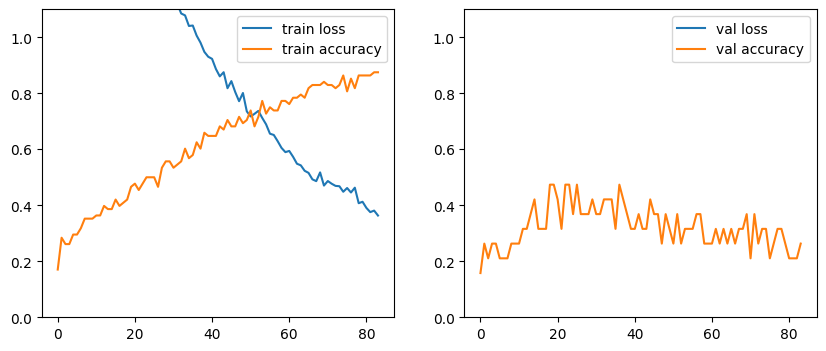

In [28]:
def plot_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

    ax1.plot(history.__dict__["history"]["loss"], label="train loss")
    ax1.plot(history.__dict__["history"]["accuracy"], label="train accuracy")
    ax1.legend()
    ax1.set_ylim(0,1.1)

    ax2.plot(history.__dict__["history"]["val_loss"], label="val loss")
    ax2.plot(history.__dict__["history"]["val_accuracy"], label="val accuracy")
    ax2.legend()
    ax2.set_ylim(0,1.1)

plot_accuracy(history)


In [46]:
model.predict(X_val)


1/1 [==============================] - 13s 13s/step


array([[0.20058276, 0.26438245, 0.00151866, 0.06125326, 0.13730417,
        0.33495858],
       [0.34381133, 0.249011  , 0.01065199, 0.03034556, 0.08285833,
        0.2833218 ],
       [0.21131498, 0.23970313, 0.0668397 , 0.14916115, 0.19563477,
        0.13734624],
       [0.23477551, 0.12720065, 0.02931015, 0.23865767, 0.31790346,
        0.05215254],
       [0.26290178, 0.21396723, 0.00650559, 0.04616275, 0.08695616,
        0.3835066 ],
       [0.00707035, 0.00441138, 0.9107653 , 0.07276207, 0.0024195 ,
        0.00257129],
       [0.14679976, 0.28339523, 0.00525381, 0.16257045, 0.23689505,
        0.1650858 ],
       [0.22487502, 0.263545  , 0.00380442, 0.0545457 , 0.20242225,
        0.25080758],
       [0.00759871, 0.00357748, 0.93354917, 0.0514291 , 0.00219477,
        0.00165069],
       [0.15177104, 0.05187789, 0.16039194, 0.38490513, 0.22860312,
        0.02245101],
       [0.33825794, 0.2648337 , 0.00603106, 0.03687385, 0.05025051,
        0.30375296],
       [0.01867431, 0

: 

In [ ]:
from backend.params import *


In [ ]:
local_model_directory = os.path.join(LOCAL_REGISTRY_PATH)
local_model_paths = glob.glob(f"{local_model_directory}*")

most_recent_model_path_on_disk = sorted(local_model_paths)[-1]


In [41]:
from backend.ml_logic.registry import save_model, load_model


In [40]:
save_model(model)


/home/jarisfenner/code/Kaaykun/SignFlow/backend/../models/20231124-144243.h5 updated function 2
20231124-144243.h5
✅ Model saved locally


In [42]:
test = load_model()


In [43]:
test
